# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
import pmdarima as pm

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=InterpolationWarning)

In [4]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Helper Functions

In [5]:
def compare_item(item_code_1,item_code_2):
    '''This functions shows the descriptive information about the two comparing items.'''
    
    for c in o_col:
        if c not in ['PER_TAG','date']:
            print(c+':\t\t',df[df['ITEM_CODE']==item_code_1][c].unique(),df[df['ITEM_CODE']==item_code_2][c].unique())
            

In [6]:
def plot_timeseries(item,date,retailer):
    '''Plots trendline for given item and mentioned retailer.'''
    
    y=df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)]['VOLUME'].values
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y,'o-',color='green')
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume across the time',fontsize=20)
    plt.show()

In [7]:
def plot_corr(segment,retailer,annot=True):
    '''This functions plots the correlation heatmap for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    plt.figure(figsize=(15,12))
    sns.heatmap(dummy.corr(),annot=annot)
    plt.show()
    
def get_corr(segment,retailer):
    '''This functions shows the correlation coefficient values for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    
    return dummy.corr()

In [8]:
def get_highest(correlation_dataframe,correlation_value):
    '''This function returns the multi indexed dataframe showing items having highest correlation value'''
    
    New=pd.DataFrame()
    for col in correlation_dataframe.columns:
        item_1=[col]*correlation_dataframe[(correlation_dataframe[col].abs()>correlation_value)&(correlation_dataframe[col]!=1)][[col]].shape[0]
        item_2=list(correlation_dataframe[(correlation_dataframe[col].abs()>correlation_value)&(correlation_dataframe[col]!=1)][[col]].index)
        item_1=[int(x) for x in item_1]
        item_2=[int(x) for x in item_2]
        
        corr=list(correlation_dataframe[(correlation_dataframe[col].abs()>correlation_value)&(correlation_dataframe[col]!=1)][[col]].values)
        T=pd.DataFrame({'Item_1':item_1,
                       'Item_2':item_2,
                       'Corr':corr})
        T['Corr']=T['Corr'].apply(lambda x:x[0])
        New=pd.concat([New,T],ignore_index=True)
    
    New.set_index(["Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return New

In [9]:
def segment_wise_correlation(dataframe,retailer,corr_value):
    '''This functions returns the multi indexed dataframe containing items with high correlation value for 
    all the segments of a dataframe.'''
    
    
    T=pd.DataFrame()
    for seg in dataframe[dataframe['RETAILER']==retailer]['SEGMENT'].unique():
        New=get_highest(get_corr(seg,retailer),corr_value)
        New.reset_index(inplace=True)
        New['SEGMENT']=[seg]*New.shape[0]
        T=pd.concat([T,New],ignore_index=True)
    T.set_index(["SEGMENT","Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return T

In [10]:
def correlated_items_dataframe(item,segment,retailer,corr_value):
    '''This function returns dataframe containing Volume Sales of given correlated items.'''
    
    item_list=[int(x) for x in get_highest(get_corr(segment,retailer),corr_value).loc[item,:].index]
    N=pd.DataFrame()
    T=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
    T.reset_index(inplace=True,drop=True)
    T=T.rename(columns={T.columns[0]: item})
    for item in item_list:
        N=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
        N.reset_index(inplace=True,drop=True)
        N=N.rename(columns={N.columns[0]: item})
        T=pd.concat([T,N],axis=1)
    T.set_index(df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)]['date'].values,inplace=True)
    
    return T

In [11]:
def plot_correlated_trendlines(T,date):
    '''This function plots trendlines of given correlated items.'''
    
    item2_list=[int(col) for col in T.columns[1:-3]]
    y1=T[T.columns[0]]
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y1,'o-')
    leg=[T.columns[0]]
    
    for y in item2_list:
        ax.plot(x,T[[y]].values,'o-')
        leg.append(y)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume Trend across Time ',fontsize=20)
    plt.legend(leg)
    plt.show()

In [12]:
def plot_correlated_trendlines_separately(dataframe):
    '''This function plots trendlines of highly correlated items separately.'''
    
    fig, axes = plt.subplots(nrows=dataframe.shape[1], ncols=1, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        y=dataframe[dataframe.columns[i]]
        x=date
        if i==0:
            ax.plot(x,y,'.-',color='red' ,linewidth=0.4)
        else:
            ax.plot(x,y,'.-' ,linewidth=0.4)
        ax.set_title(dataframe.columns[i])
        plt.xticks(rotation=90,fontsize=14)
        #plt.xlabel('Dates',fontsize=20)
        plt.yticks(rotation=0,fontsize=14)
        #plt.ylabel(str(item),fontsize=14)
        ax.xaxis_date()     # interpret the x-axis values as dates
        fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
        #plt.grid(True)
        #plt.title('Volume Sales for {}'.format(item),fontsize=20)
        #ax.xaxis.set_ticks_position(None)
        #ax.yaxis.set_ticks_position(None)
        #ax.spines['Top'].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();

In [13]:
def ADF_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series contains a unit root, it is not stationary.
       Alternative Hypothesis: There is no unit root.
       
       Low p-values are preferable. If the test returns a p-value BELOW the chosen significance level (e.g.0.05),
       we reject the null and conclude that the series does not contain a unit root.It appears to be stationary.
       '''
    adf_test = adfuller(x, autolag="aic")
    t_stat, p_value, _, _, _, _  = adf_test
    conclusion = "non-stationary (unit root)" if p_value > ALPHA else "stationary"
    res_dict = {"ADF statistic":t_stat, "p-value":p_value, "should we difference?": (p_value > ALPHA), "conclusion": conclusion}
    return res_dict

In [14]:
def KPSS_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series is stationary around a deterministic trend (trend-stationary)
       Alternative Hypothesis: The series has a unit root. It is non-stationary.
       
       High p-values are preferable. If the test returns a p-value ABOVE the chosen significance level (e.g.0.05),
       we conclude that the series appears to be atleast trend stationary.
       
    '''
    kpss_test = kpss(x)
    t_stat, p_value, _, critical_values  = kpss_test
    conclusion = "stationary" if p_value > ALPHA else "not stationary"
    res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
    return res_dict

In [15]:
def plot_stationarity(time_series, lags,model):
    
    y=time_series
    # decompose the time series into trend, seasonality and residuals
    decomp = seasonal_decompose(time_series, 
                                   model=model, 
                                   period=lags)
    # decomp.plot()
    # plt.show()
    trend = decomp.trend
    seas = decomp.seasonal
   
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    #ax4 = plt.subplot2grid((3, 3), (1, 1))
    ax5 = plt.subplot2grid((3, 3), (2, 0))
    ax6 = plt.subplot2grid((3, 3), (2, 1))
    y.plot(ax=ax1)
    #ax1.set_title("Rolling 12-Month Temperature")
    ax1.set_title(y.name)
    trend.plot(ax=ax2)
    ax2.set_title("Trend Component")
    seas.plot(ax=ax3)
    ax3.set_title("Seasonal Component")

    # resid.plot(ax=ax4)
    # ax4.set_title("Residual Component")
    
    plot_acf(y, lags=lags, zero=False, ax=ax5);
    plot_pacf(y, lags=lags, zero=False, ax=ax6);
    plt.tight_layout()

In [16]:
def get_segment(segment,retailer,date):
    item=df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)]['ITEM_CODE'].unique()[0]
    T=correlated_items_dataframe(item,segment,retailer,0)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [17]:
def get_items_from_segment(item,segment,retailer,date,corr_value=0.8):
    T=correlated_items_dataframe(item,segment,retailer,corr_value)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    #T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [18]:
def plot_timeseries_segment(dataframe,segment):
    x=get_dates(dataframe)
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,dataframe[segment].values,'o-',color='blue',linewidth=2.15)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('{} volume across the time'.format(segment),fontsize=20)
    plt.show()

In [19]:
def get_dates(dataframe):
    date=dataframe
    date.reset_index(inplace=True,drop=True)
    date=pd.to_datetime(date['date'])
    return date

In [20]:
def check_stationarity(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns[:-3]:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    N.set_index(['Item','Results'],inplace=True,drop=True)
    
    return N

# Reading the data

In [21]:
df=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\DF_dataframe_final.csv')

##### Creating a dictionary containing description about the particular item

In [22]:
item_detail={}
for man in df['MANUFACTURER'].unique():
    for item in df[df['MANUFACTURER']==man]['ITEM_CODE'].unique():
        item_detail[item]=df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique()
        #print(item,df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique())

##### Creating a list containing names for all the object type columns

In [23]:
o_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='O':
        o_col.append(c)

##### Creating a list containing names for all the integer type columns

In [24]:
i_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='int':
        i_col.append(c)

##### Creating a list containing names for all the float type columns

In [25]:
f_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='float':
        f_col.append(c)

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [26]:
rem_f_col=[]
for i in f_col[:-117]:
    if df[i].describe()['std']==0 and df[i].describe()['mean']==0:
        rem_f_col.append(i)
        

##### Creating a list containing names for all the columns which contains SINE values       

In [27]:
sine_col=f_col[-117:]

##### Removing all the selected columns

In [28]:
f_col=[ele for ele in f_col if ele not in rem_f_col+sine_col]

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [29]:
zero_col=[]
for col in f_col:
    if df.shape[0]*0.95<=df[df[col]==0].shape[0]:
        zero_col.append(col)
        #print(col,df[df[col]==0].shape[0])

##### Removing all the selected columns

In [30]:
f_col=[ele for ele in f_col if ele not in zero_col]

In [31]:
o_col=[ele for ele in o_col if ele not in ['WEEK_END_DATE', 'WEEK_END_DATE_New']]

Date Timeline<br>
print(df['date'].unique(),sep='\t')

In [32]:
date=get_dates(df[(df['ITEM_CODE']==9300701525033)&(df['RETAILER']=='Woolworths')][['date']])

# 1.  Segment<br>
# (a). Retailer<br>
## (i). Plotting the TimeSeries.

In [33]:
segment='Automatic Mist Diffusers'
retailer='Woolworths'

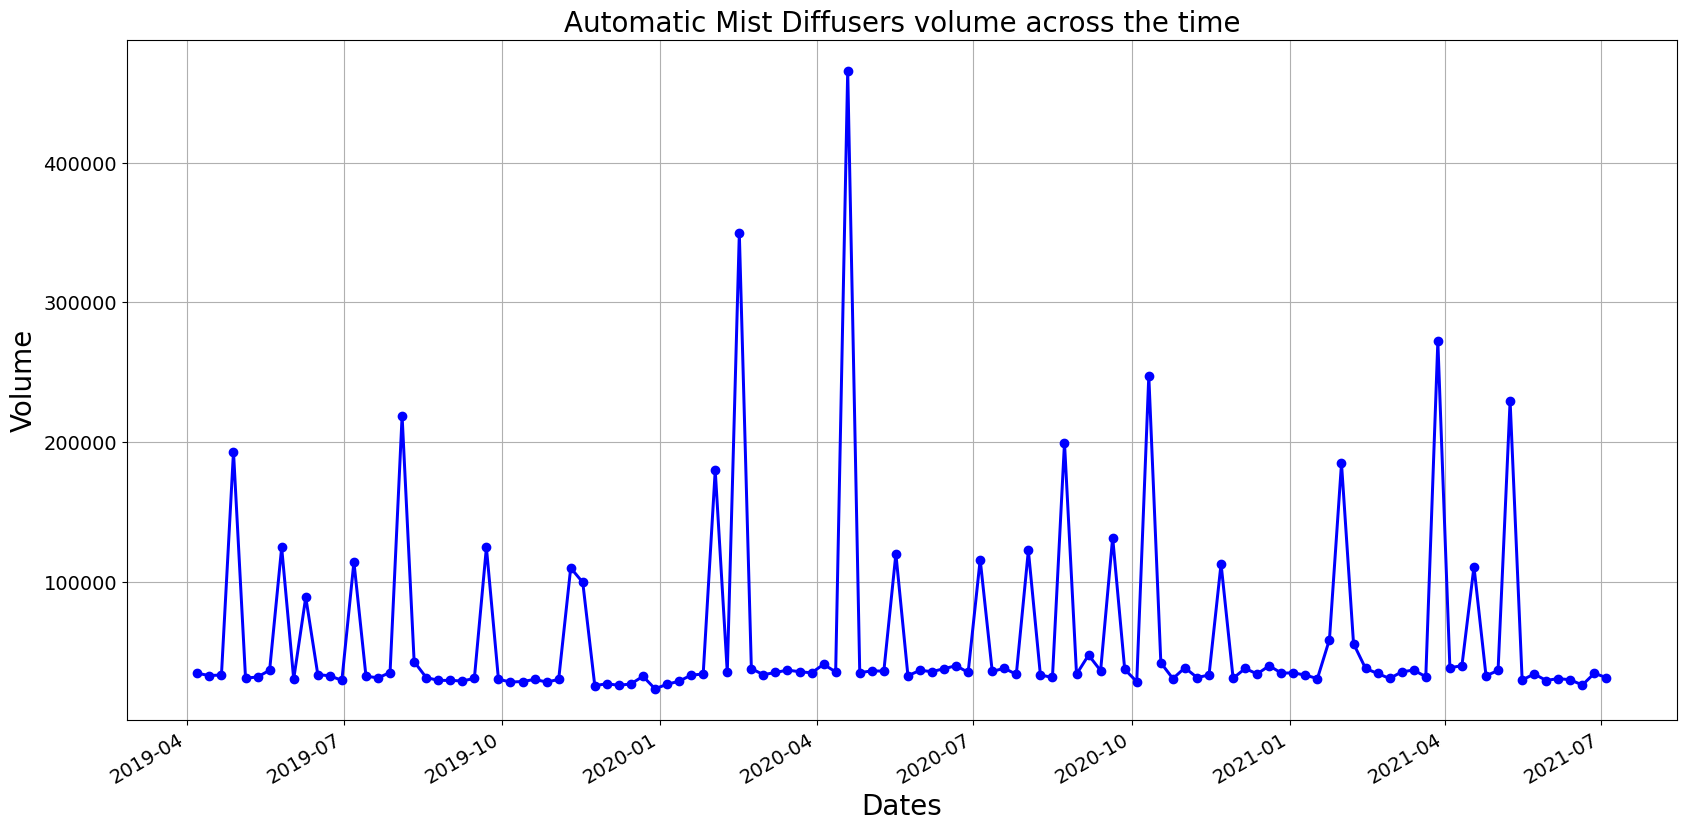

In [34]:
T=get_segment(segment,retailer,date)
plot_timeseries_segment(T,segment)

## (ii). Decomposition of TimeSeries.

##### get the plots for the time series before differencing

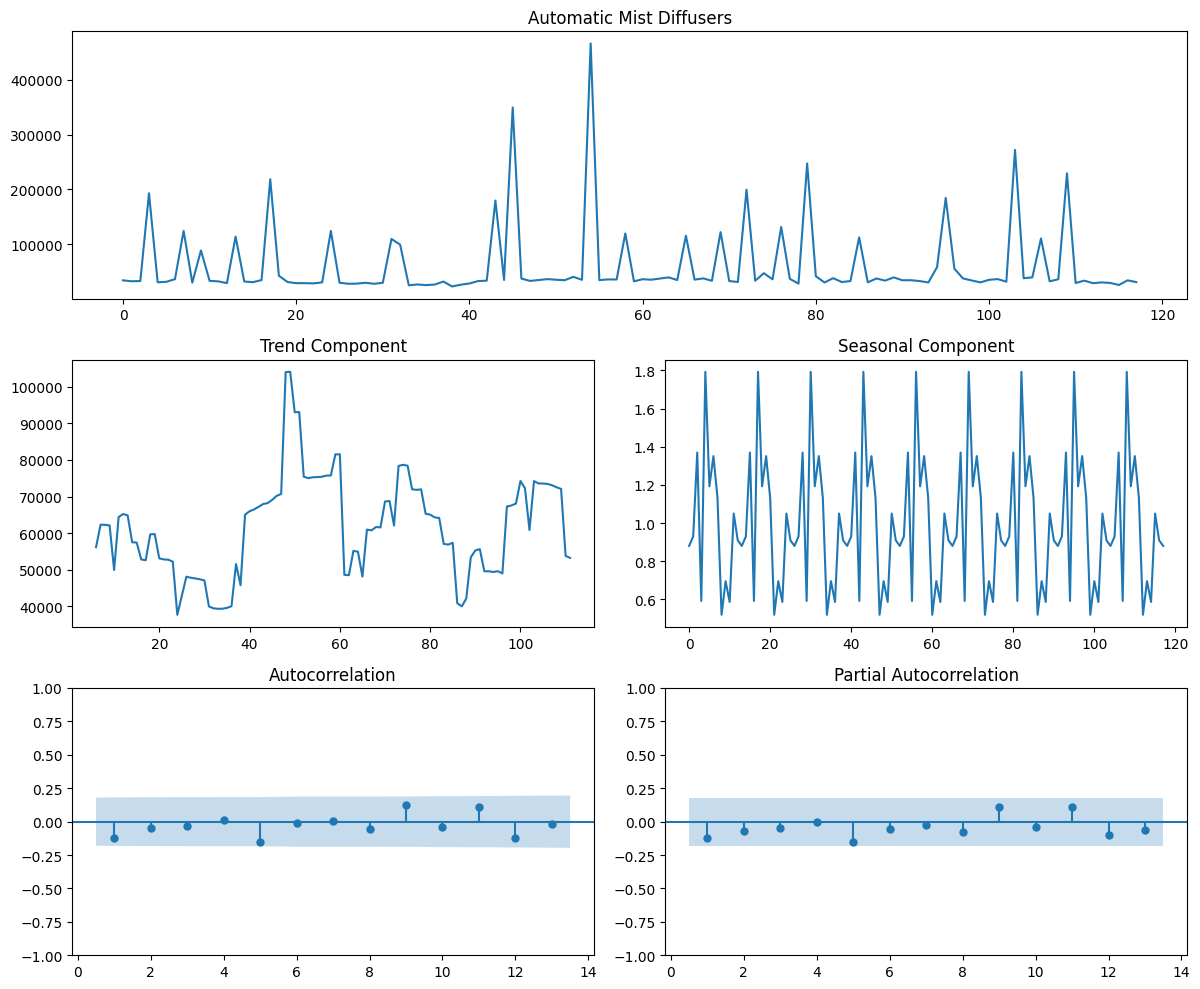

In [35]:
plot_stationarity(T[segment], 13,'multiplicative')

## (iii). Confirmation tests for Stationarity of TimeSeries.

In [36]:
check_stationarity(T)

ADF  \
Item                     Results                                             
9300701525019            Test Statistics                           -11.549   
                         p-value                                     0.000   
                         Differencing Required                       False   
                         Conclusion                             stationary   
9300701525026            Test Statistics                            -0.032   
                         p-value                                     0.956   
                         Differencing Required                        True   
                         Conclusion             non-stationary (unit root)   
9300701525033            Test Statistics                           -11.994   
                         p-value                                     0.000   
                         Differencing Required                       False   
                         Conclusion                             stationary   
9300701525040            Test Statistics                           -12.386   
                         p-value                                     0.000   
                         Differencing Required                       False   
                         Conclusion                             stationary   
9300701529161            Test Statistics                            -3.920   
                         p-value                                     0.002   
                         Differencing Required                       False   
                         Conclusion                             stationary   
9300701744298            Test Statistics                           -11.485   
                         p-value                                     0.000   
                         Differencing Required                       False   
                         Conclusion                             stationary   
Automatic Mist Diffusers Test Statistics                           -12.165   
                         p-value                                     0.000   
                         Differencing Required                       False   
                         Conclusion                             stationary   

                                                          KPSS  
Item                     Results                                
9300701525019            Test Statistics                 0.118  
                         p-value                         0.100  
                         Differencing Required           False  
                         Conclusion                 stationary  
9300701525026            Test Statistics                 1.009  
                         p-value                         0.010  
                         Differencing Required            True  
                         Conclusion             not stationary  
9300701525033            Test Statistics                 0.060  
                         p-value                         0.100  
                         Differencing Required           False  
                         Conclusion                 stationary  
9300701525040            Test Statistics                 0.075  
                         p-value                         0.100  
                         Differencing Required           False  
                         Conclusion                 stationary  
9300701529161            Test Statistics                 1.006  
                         p-value                         0.010  
                         Differencing Required            True  
                         Conclusion             not stationary  
9300701744298            Test Statistics                 0.101  
                         p-value                         0.100  
                         Differencing Required           False  
                         Conclusion                 stationary  
Automatic Mist Diffusers Test Statistics

## (iv). Descriptive Statistics of TimeSeries.

### Histogram of the TimeSeries

Median	 34500.000
count      118.000
mean     60530.678
std      68917.185
min      23180.000
25%      30865.000
50%      34500.000
75%      39720.000
max     465880.000
Name: Automatic Mist Diffusers, dtype: float64


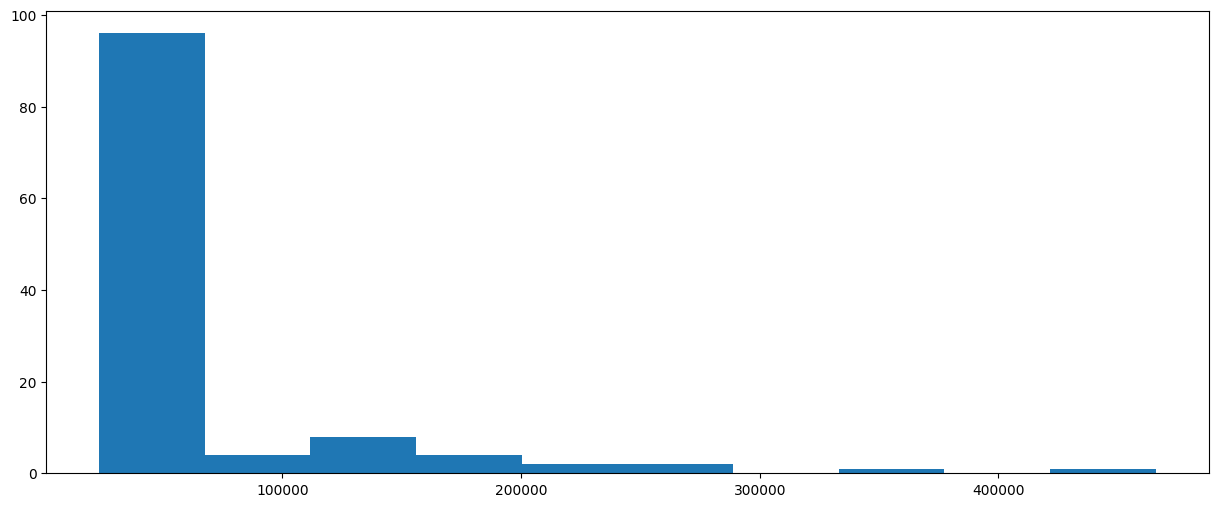

In [37]:
print("Median\t {:.3f}".format(T[segment].median()))
print(T[segment].describe())
plt.figure(figsize=(15,6))
plt.hist(T[segment])
plt.show()

In [38]:
Mid=T[segment].median()

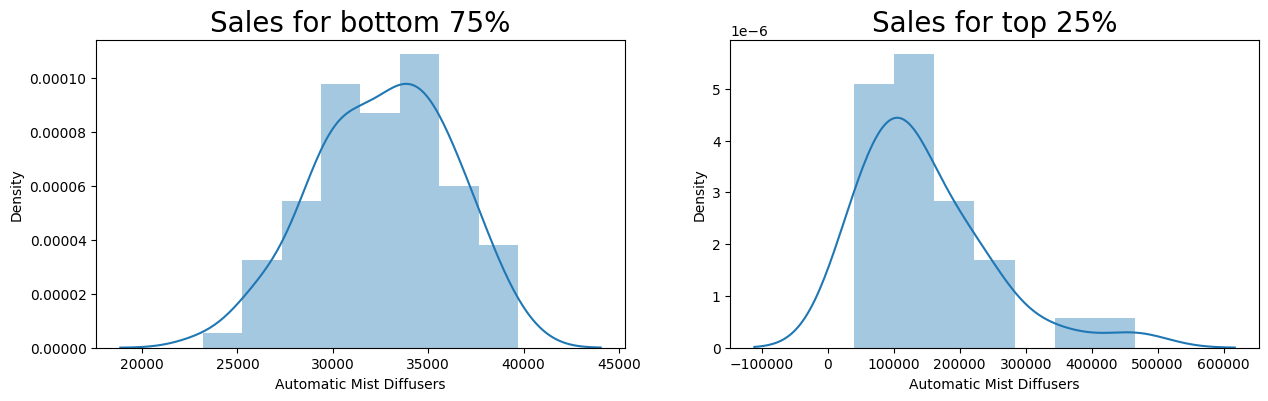

In [39]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
sns.distplot(T[T[segment]<=T[segment].describe()['75%']][segment],ax=axes[0])
axes[0].set_title('Sales for bottom 75%',fontsize=20)
sns.distplot(T[T[segment]>T[segment].describe()['75%']][segment],ax=axes[1])
axes[1].set_title('Sales for top 25%',fontsize=20)
plt.show()

### Barplots

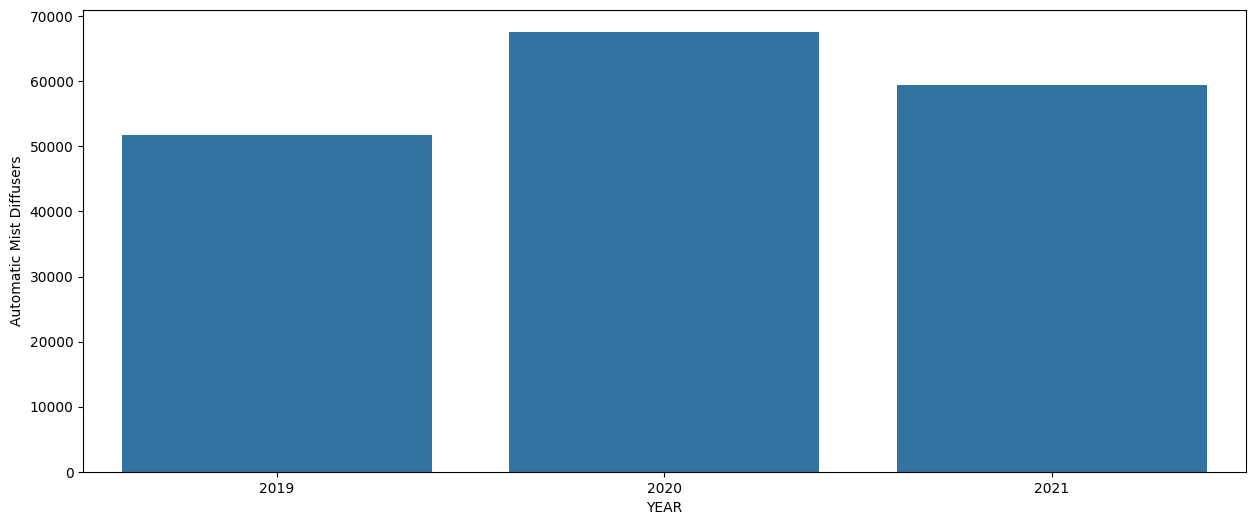

In [40]:
fig=plt.figure(figsize=(15,6))
sns.barplot(x='YEAR',y=segment,data=T,ci=0,orient='v')
plt.show()

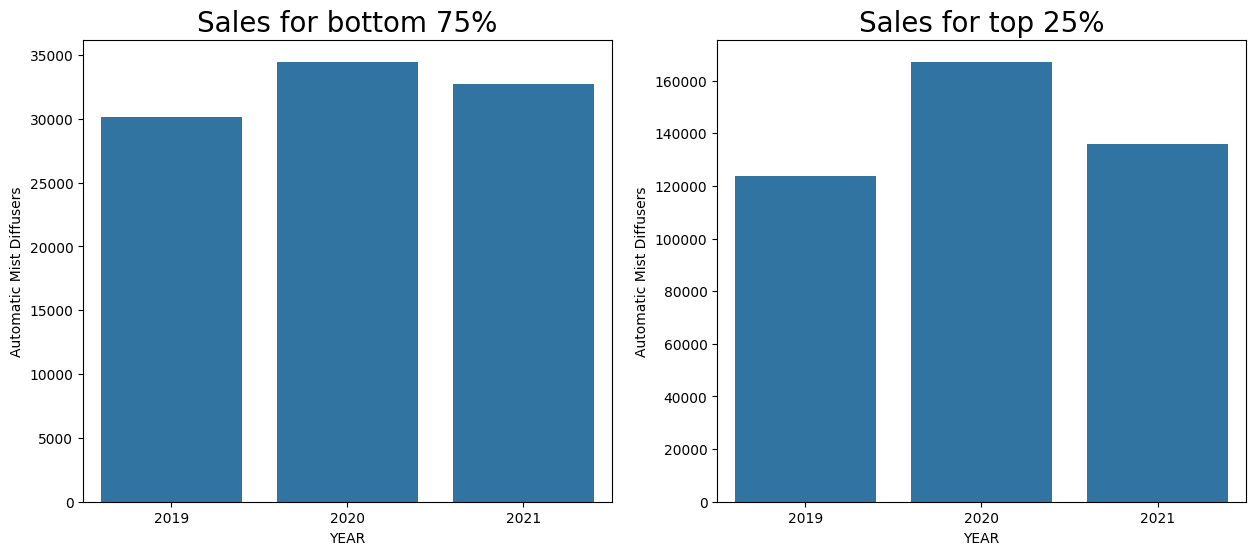

In [41]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
sns.barplot(x='YEAR',y=segment,data=T[T[segment].apply(lambda x:x<=T[segment].describe()['75%'])],ci=0,orient='v',ax=axes[0])
axes[0].set_title('Sales for bottom 75%',fontsize=20)
sns.barplot(x='YEAR',y=segment,data=T[T[segment].apply(lambda x:x>T[segment].describe()['75%'])],ci=0,orient='v',ax=axes[1])
axes[1].set_title('Sales for top 25%',fontsize=20)
plt.show()

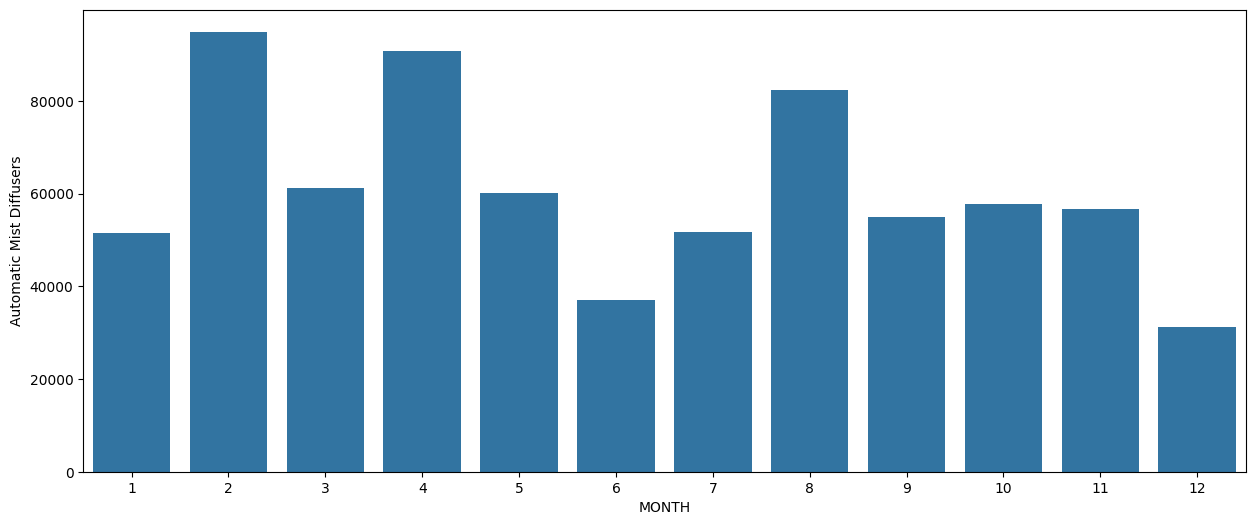

In [42]:
fig=plt.figure(figsize=(15,6))
sns.barplot(x='MONTH',y=segment,data=T,ci=0,orient='v')
plt.show()

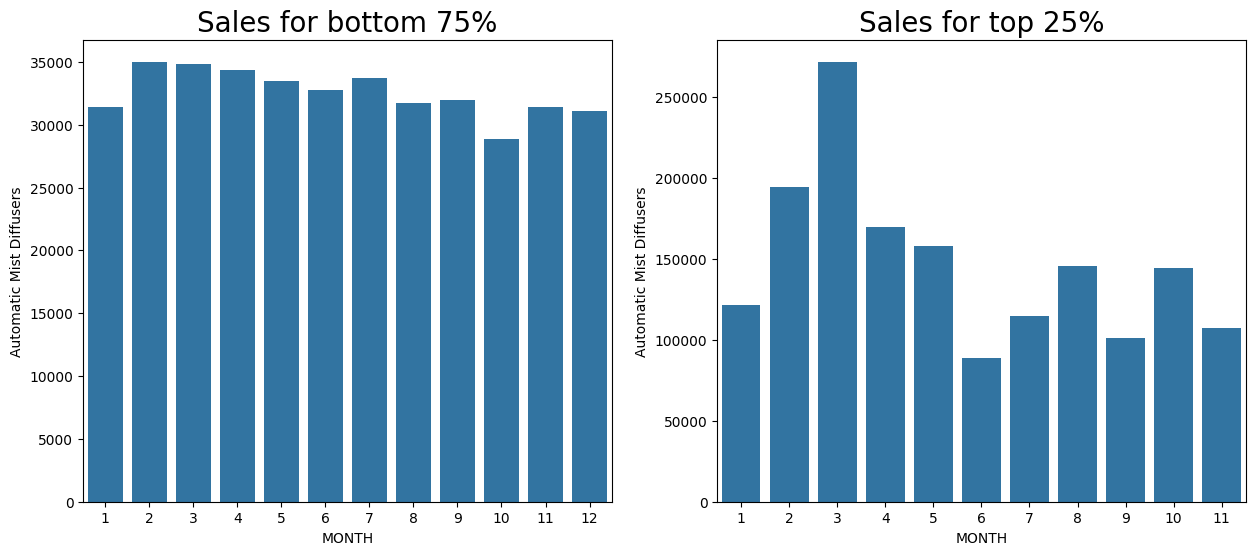

In [43]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
sns.barplot(x='MONTH',y=segment,data=T[T[segment].apply(lambda x:x<=T[segment].describe()['75%'])],ci=0,orient='v',ax=axes[0])
axes[0].set_title('Sales for bottom 75%',fontsize=20)
sns.barplot(x='MONTH',y=segment,data=T[T[segment].apply(lambda x:x>T[segment].describe()['75%'])],ci=0,orient='v',ax=axes[1])
axes[1].set_title('Sales for top 25%',fontsize=20)
plt.show()

### Crossed Barplots

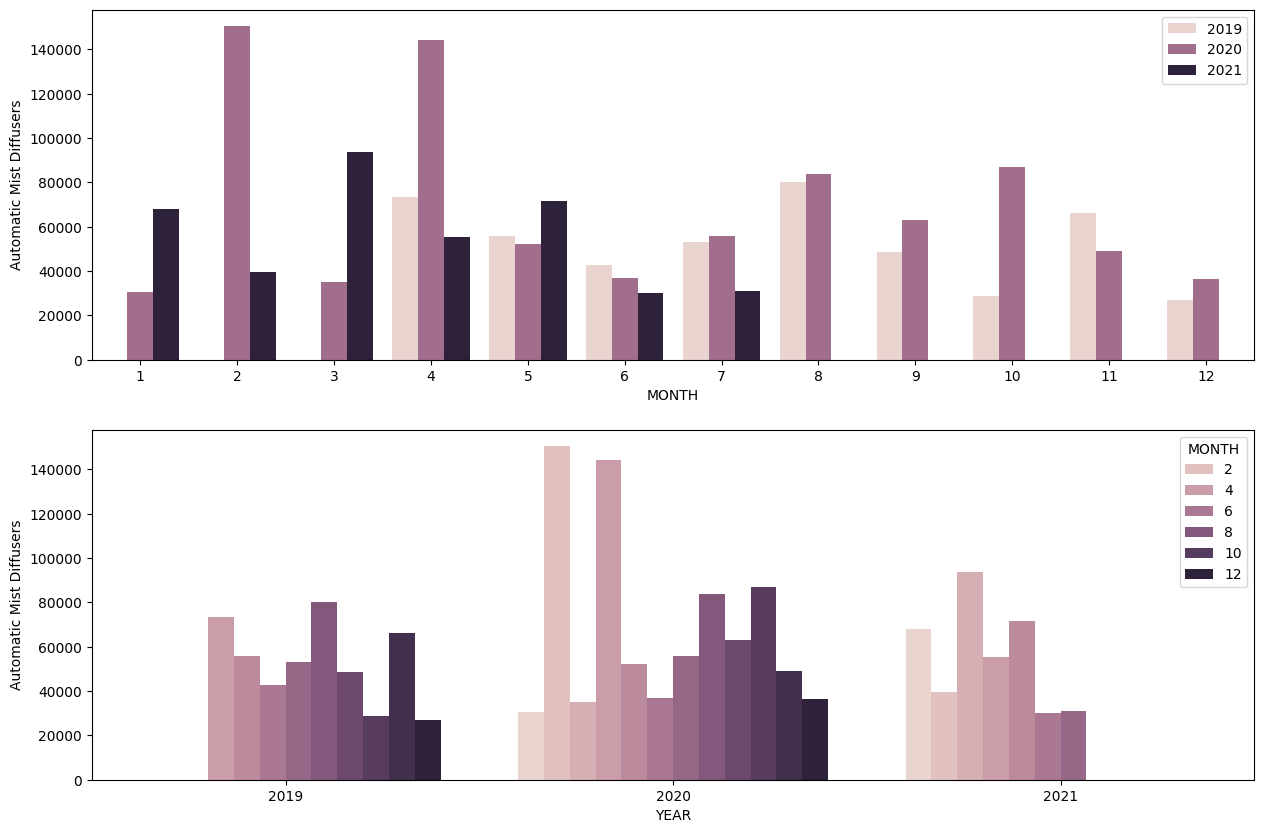

<Figure size 1000x700 with 0 Axes>

In [44]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.figure(figsize=(10,7))
sns.barplot(x='MONTH',y=segment,data=T,hue='YEAR',ci=0,orient='v',ax=axes[0])
sns.barplot(x='YEAR',y=segment,data=T,hue='MONTH',ci=0,orient='v',ax=axes[1])
axes[0].legend(loc=1)
plt.show()

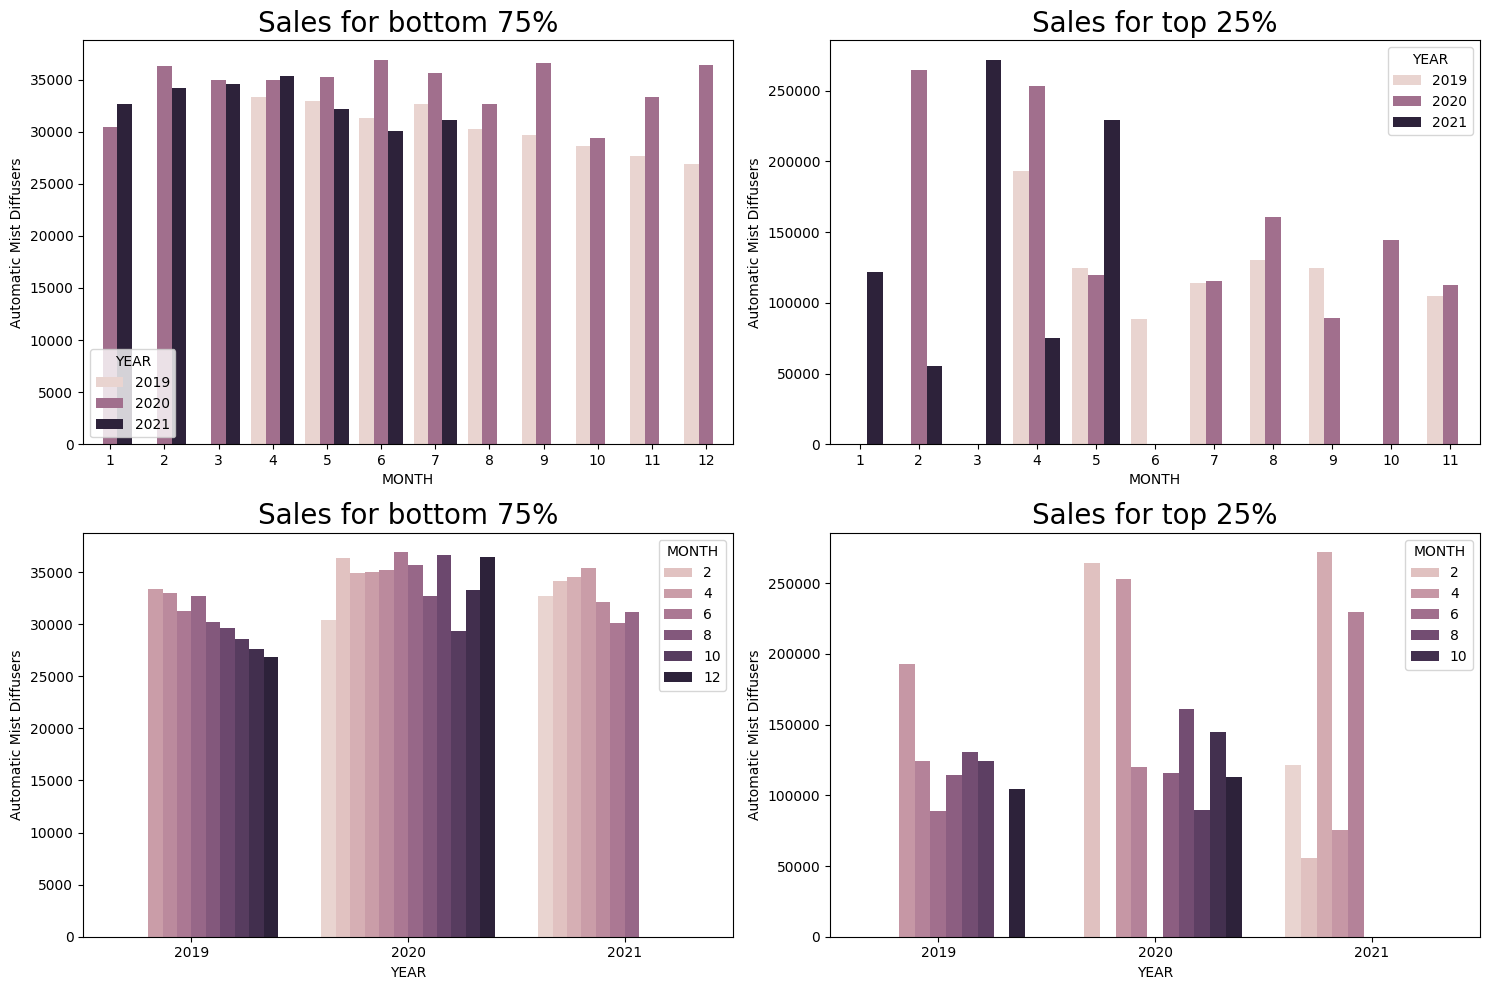

In [45]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
sns.barplot(x='MONTH',y=segment,data=T[T[segment].apply(lambda x:x<=T[segment].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[0,0])
axes[0,0].set_title('Sales for bottom 75%',fontsize=20)
sns.barplot(x='MONTH',y=segment,data=T[T[segment].apply(lambda x:x>T[segment].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[0,1])
axes[0,1].set_title('Sales for top 25%',fontsize=20)
sns.barplot(x='YEAR',y=segment,data=T[T[segment].apply(lambda x:x<=T[segment].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[1,0])
axes[1,0].set_title('Sales for bottom 75%',fontsize=20)
sns.barplot(x='YEAR',y=segment,data=T[T[segment].apply(lambda x:x>T[segment].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[1,1])
axes[1,1].set_title('Sales for top 25%',fontsize=20)
fig.tight_layout()
plt.show()

## Correlated Items Analysis

In [46]:
get_highest(get_corr(segment,retailer),0.8)

Corr
Item_1            Item_2                 
9300701525019.000 9300701744298.000 0.997
9300701525026.000 9300701525040.000 0.822
9300701525033.000 9300701525040.000 0.922
9300701525040.000 9300701525026.000 0.822
                  9300701525033.000 0.922
9300701744298.000 9300701525019.000 0.997

### 0.) [9300701525019, 9300701744298]

In [47]:
items=[9300701525019, 9300701744298]

### Plotting TimeSeries

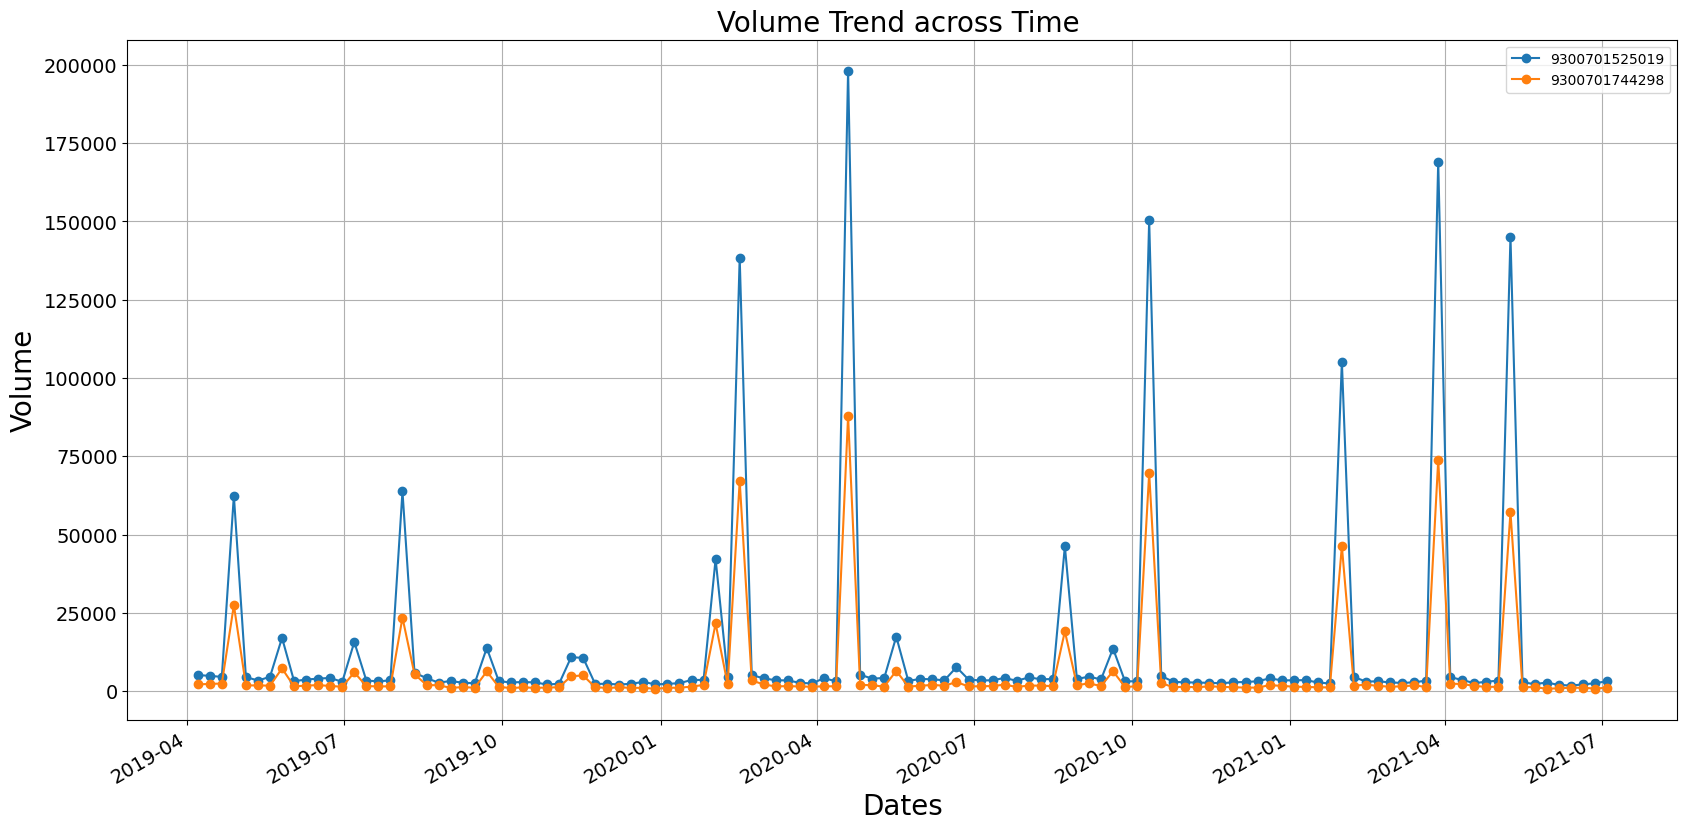

SKU No. 9300701525019 : ['Air Wick Essential Mist Diffuser Prime Peony & Jasmine 20mL'] .
SKU No. 9300701744298 : ['Air Wick Essential Mist Mandarin & Sweet Orange 20mL'] .


In [48]:
T=get_segment(segment,retailer,date)[items+['date','MONTH','YEAR']]
plot_correlated_trendlines(T,date)
for item in T.columns[:-3]:
    print("SKU No. {} : {} .".format(item,item_detail[item]))

### Decomposition of TimeSeries.

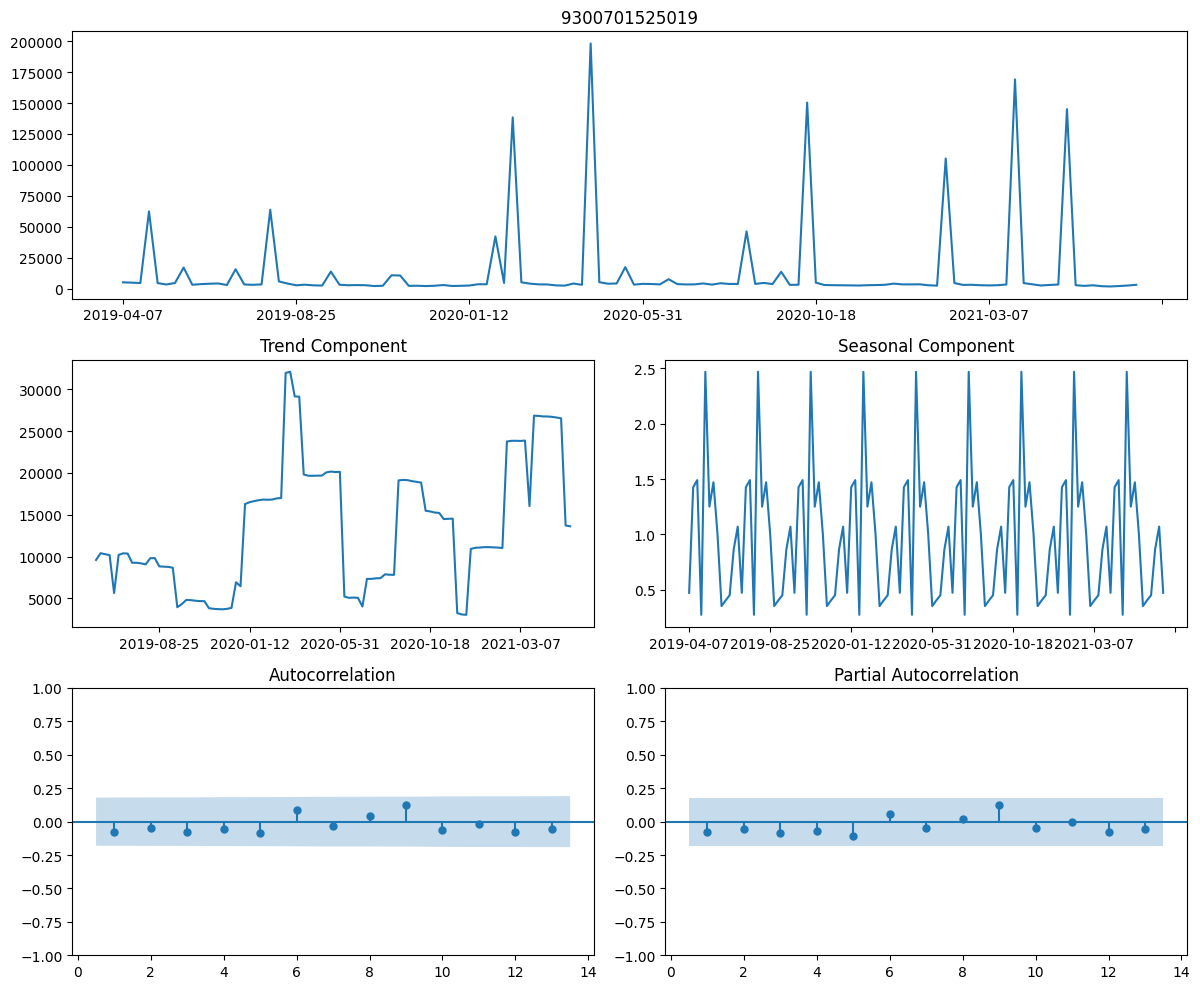

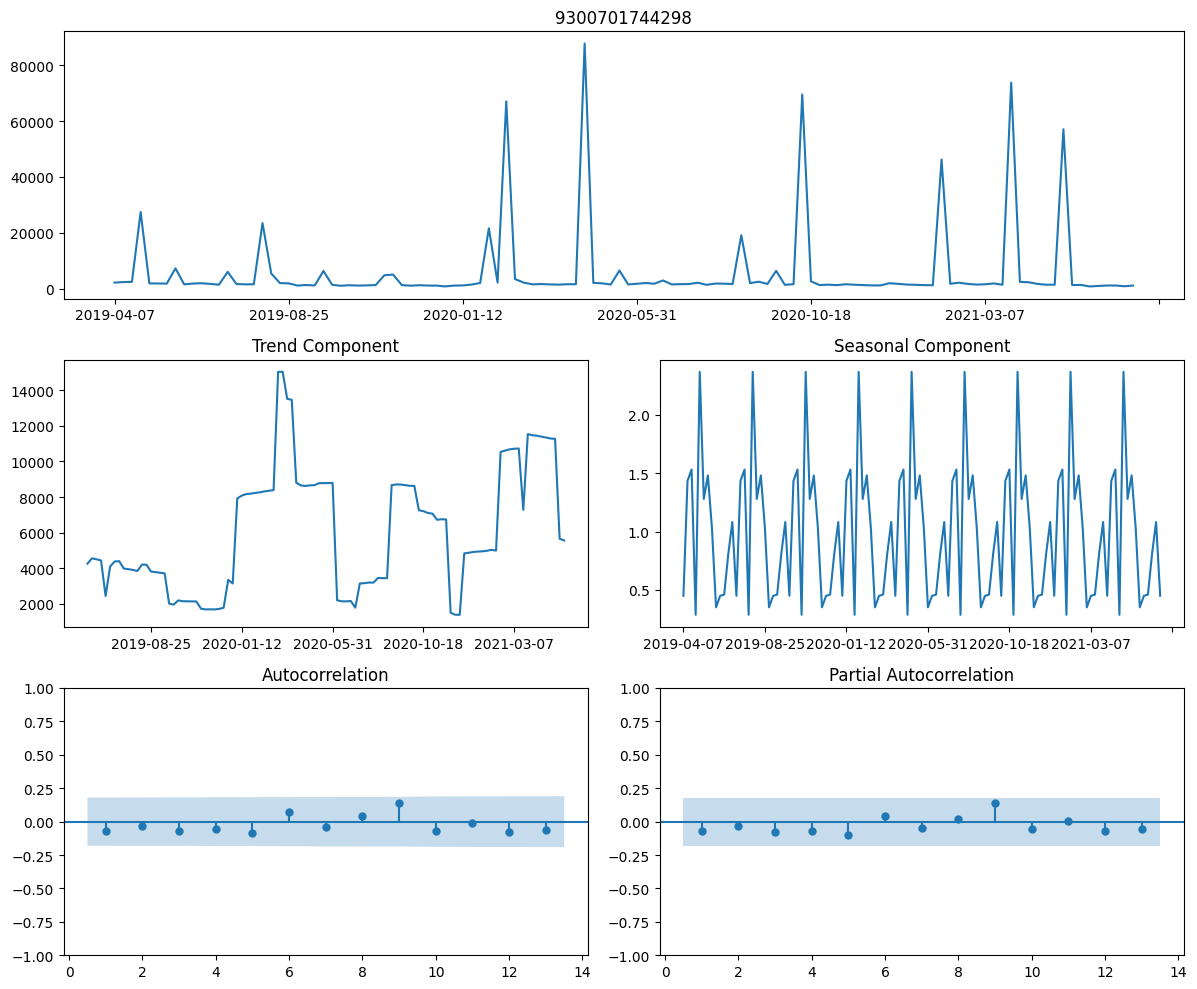

In [49]:
for item in T.columns[:-3]:
    if 0 in T[item].values:
        plot_stationarity(T[item],4,'additive')
    else:
        plot_stationarity(T[item],13,'multiplicative')

### Checking Stationarity

In [50]:
check_stationarity(T)

ADF        KPSS
Item          Results                                      
9300701525019 Test Statistics           -11.549       0.118
              p-value                     0.000       0.100
              Differencing Required       False       False
              Conclusion             stationary  stationary
9300701744298 Test Statistics           -11.485       0.101
              p-value                     0.000       0.100
              Differencing Required       False       False
              Conclusion             stationary  stationary

###  Descriptive Statistics of TimeSeries.

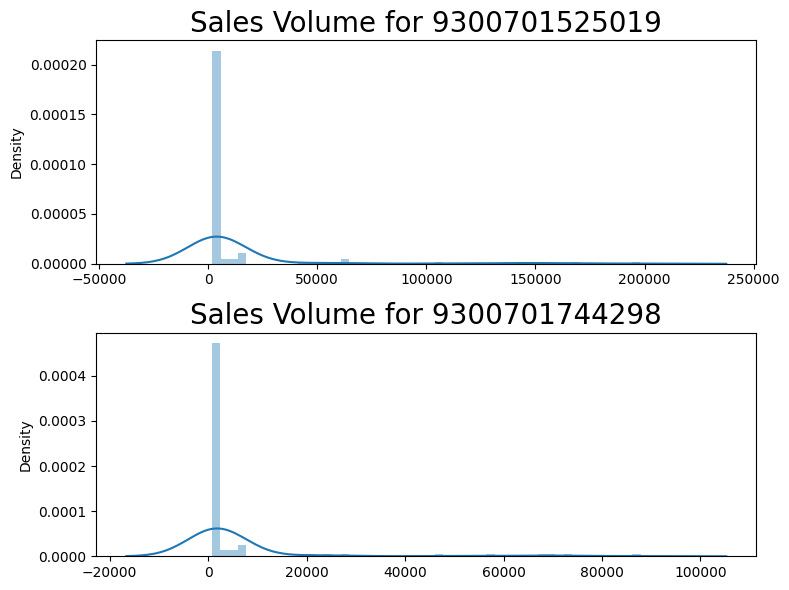

In [51]:
if len(T.columns)==4:
    fig=plt.figure(figsize=(8,6))
    sns.distplot(T[item])
    plt.title('Sales Volume for {}'.format(str(int(item))),fontsize=20)
    plt.xlabel(None,fontsize=16)
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=1,figsize=(8,6))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[item],ax=axes[i])
        axes[i].set_title('Sales Volume for {}'.format(str(int(item))),fontsize=20)
        axes[i].set_xlabel(None,fontsize=16)
    fig.tight_layout()
    plt.show()

In [52]:
T[T.columns[:-3]].describe().T

count      mean       std      min      25%      50%      75%  \
9300701525019 118.000 13246.949 34045.478 1800.000 2805.000 3440.000 4520.000   
9300701744298 118.000  5918.644 15042.932  760.000 1290.000 1600.000 2115.000   

                     max  
9300701525019 198140.000  
9300701744298  87860.000

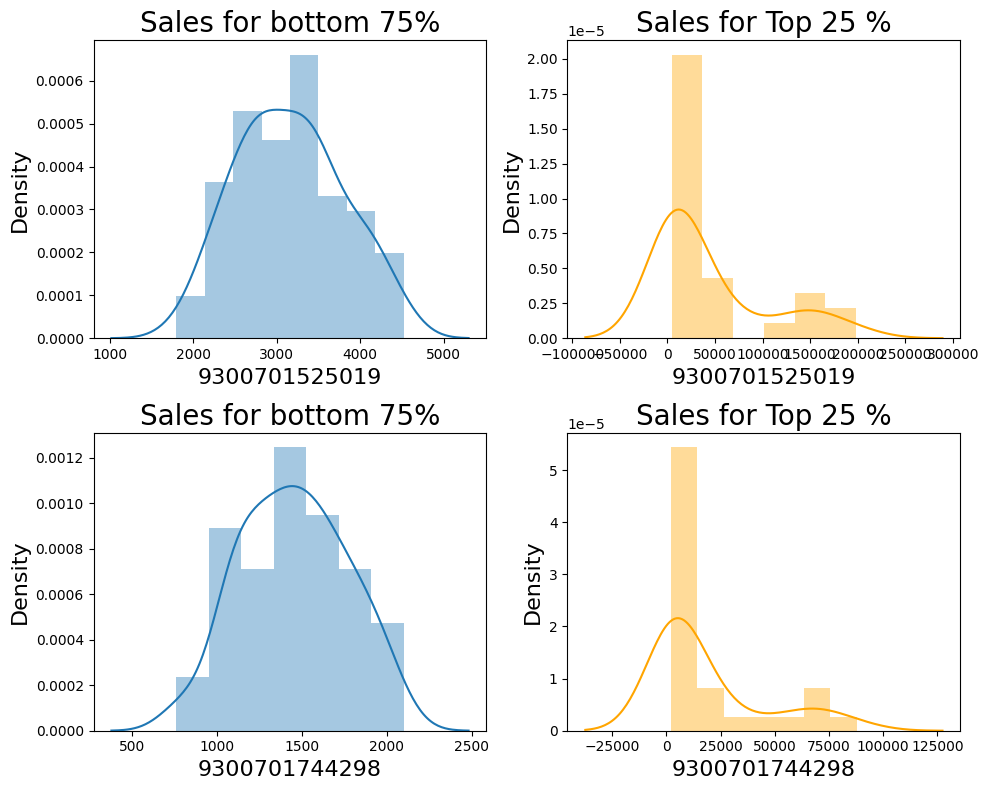

In [53]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=2,figsize=(10,8))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[T[item]<=T[item].describe()['75%']][item],ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
        axes[0].set_xlabel(item,fontsize=16)
        axes[0].set_ylabel('Density',fontsize=16)
    
        sns.distplot(T[T[item]>T[item].describe()['75%']][item],ax=axes[1],color='orange')
        axes[1].set_title('Sales for Top 25 %',fontsize=20)
        axes[1].set_xlabel(item,fontsize=16)
        axes[1].set_ylabel('Density',fontsize=16)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=2,figsize=(10,8))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[T[item]<=T[item].describe()['75%']][item],ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
        axes[i,0].set_xlabel(item,fontsize=16)
        axes[i,0].set_ylabel('Density',fontsize=16)
        
        sns.distplot(T[T[item]>T[item].describe()['75%']][item],ax=axes[i,1],color='orange')
        axes[i,1].set_title('Sales for Top 25 %',fontsize=20)
        axes[i,1].set_xlabel(item,fontsize=16)
        axes[i,1].set_ylabel('Density',fontsize=16)
    fig.tight_layout()
    plt.show()

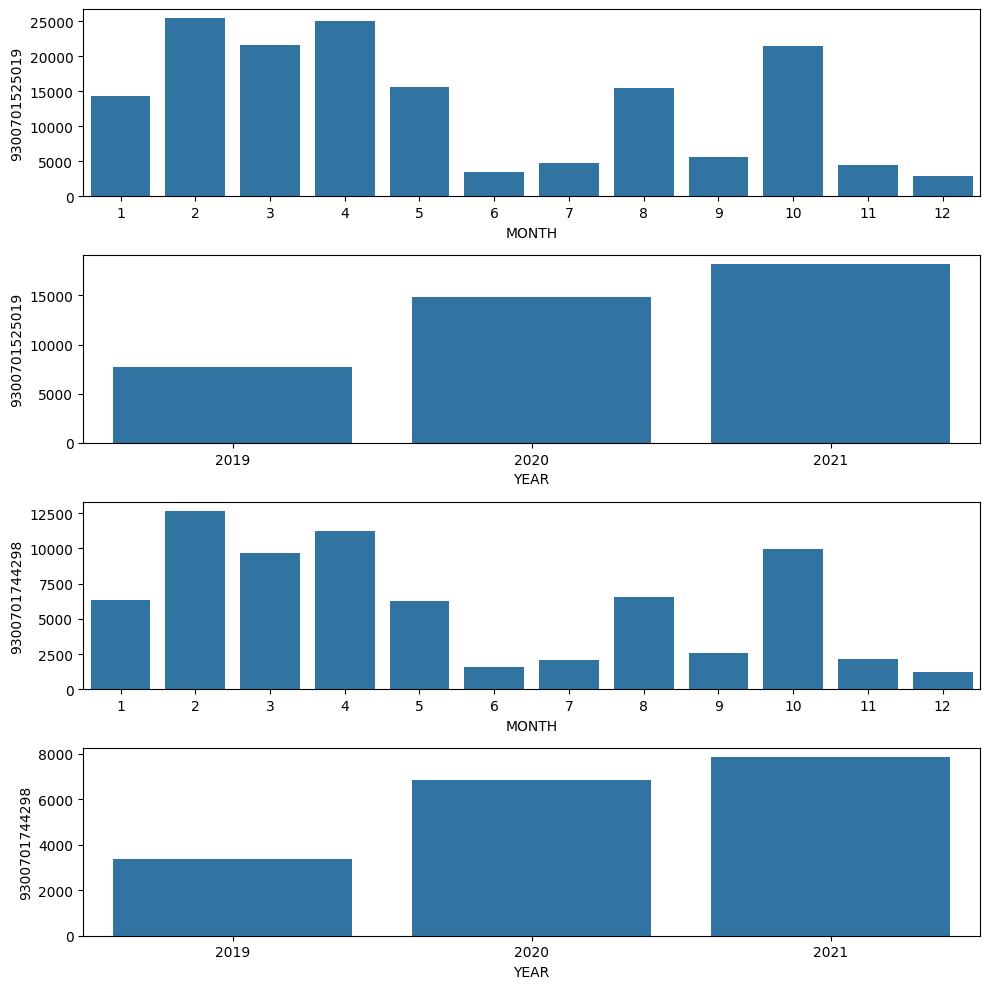

In [54]:
fig,axes=plt.subplots(nrows=(T.shape[1]-3)*2,ncols=1,figsize=(10,10))
for i,item in enumerate(T.columns[:-3]):
    sns.barplot(x='MONTH',y=item,data=T,ci=0,orient='v',ax=axes[i*2])
    sns.barplot(x='YEAR',y=item,data=T,ci=0,orient='v',ax=axes[(i*2)+1])
fig.tight_layout()
plt.show()

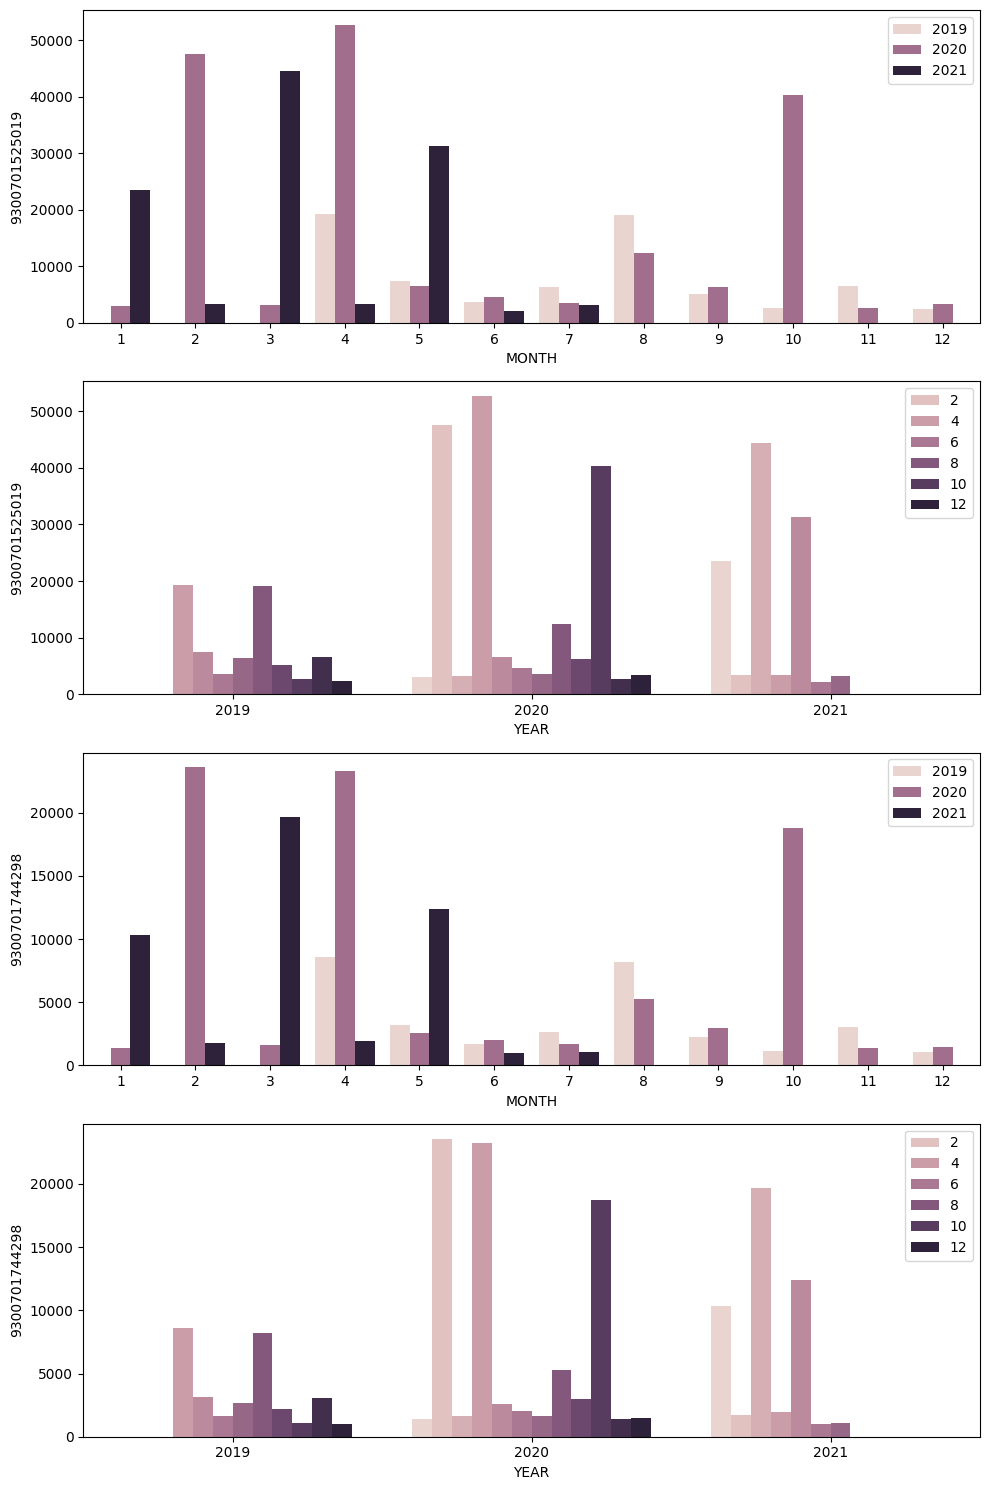

In [55]:
fig,axes=plt.subplots(nrows=(T.shape[1]-3)*2,ncols=1,figsize=(10,15))
for i,item in enumerate(T.columns[:-3]):
    
    sns.barplot(x='MONTH',y=item,data=T,hue='YEAR',ci=0,orient='v',ax=axes[i*2])
    sns.barplot(x='YEAR',y=item,data=T,hue='MONTH',ci=0,orient='v',ax=axes[(i*2)+1])
    axes[i*2].legend(loc='upper right')
    axes[(i*2)+1].legend(loc='upper right')
fig.tight_layout()
plt.show()

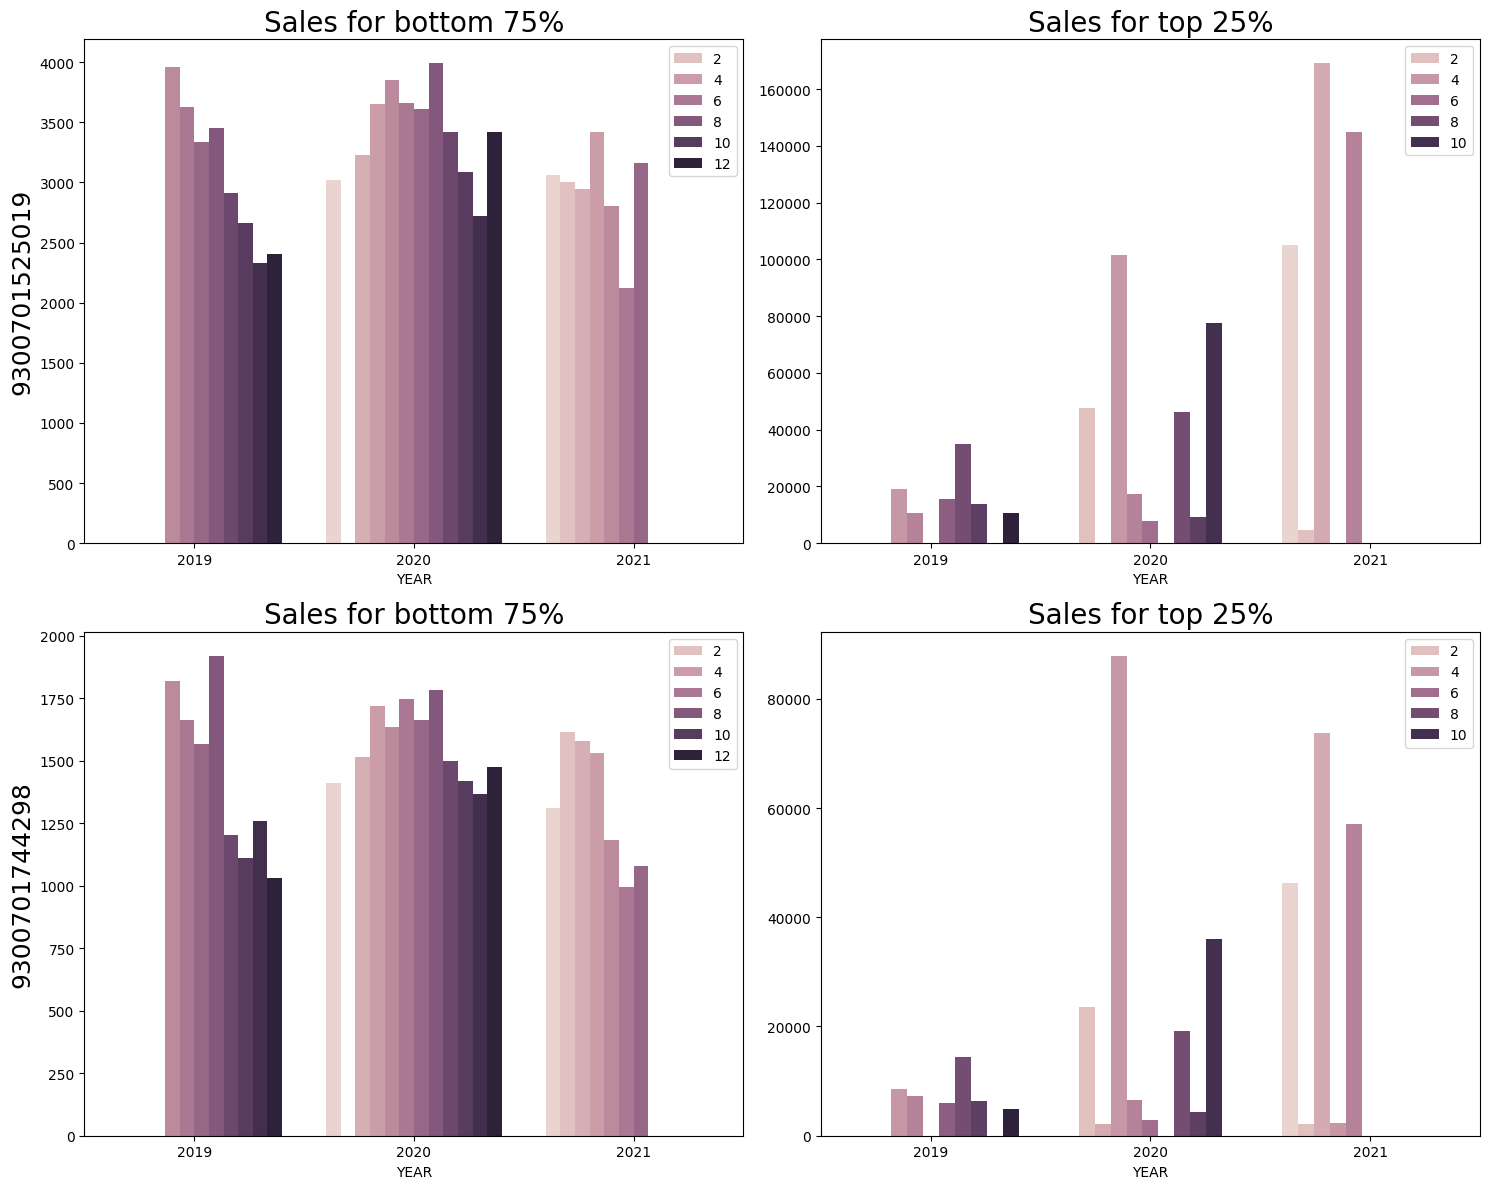

In [56]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
        
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[1])
        axes[1].set_title('Sales for top 25%',fontsize=20)
        
        axes[1].legend(loc='upper right')
        axes[0].legend(loc='upper right')
        
        axes[1].set_ylabel(ylabel=None)
        axes[0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
    
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
        
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[i,1])
        axes[i,1].set_title('Sales for top 25%',fontsize=20)
    
        axes[i,1].legend(loc='upper right')
        axes[i,0].legend(loc='upper right')
    
        axes[i,1].set_ylabel(ylabel=None)
        axes[i,0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()

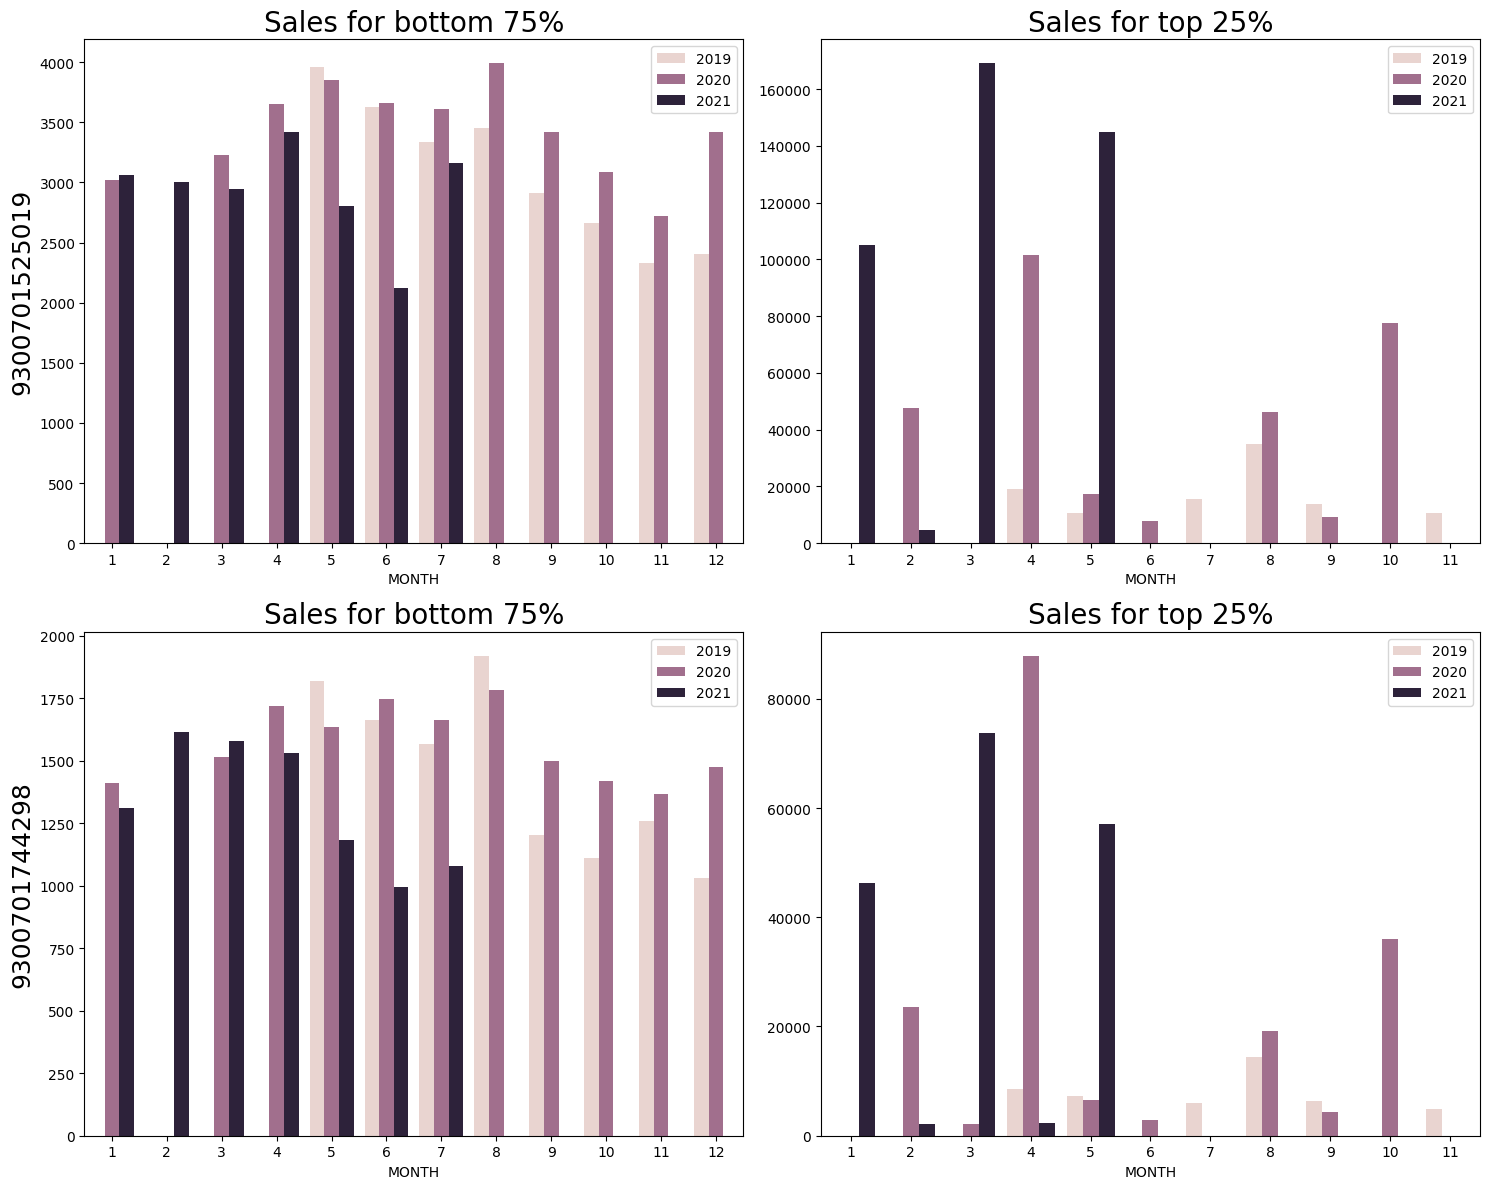

In [57]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
    
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[1])
        axes[1].set_title('Sales for top 25%',fontsize=20)
    
    
        axes[1].legend(loc='upper right')
        axes[0].legend(loc='upper right')
    
        axes[1].set_ylabel(ylabel=None)
        axes[0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
    
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[i,1])
        axes[i,1].set_title('Sales for top 25%',fontsize=20)
    
    
        axes[i,1].legend(loc='upper right')
        axes[i,0].legend(loc='upper right')
    
        axes[i,1].set_ylabel(ylabel=None)
        axes[i,0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()

## Correlated Items Analysis

In [58]:
get_highest(get_corr(segment,retailer),0.8)

Corr
Item_1            Item_2                 
9300701525019.000 9300701744298.000 0.997
9300701525026.000 9300701525040.000 0.822
9300701525033.000 9300701525040.000 0.922
9300701525040.000 9300701525026.000 0.822
                  9300701525033.000 0.922
9300701744298.000 9300701525019.000 0.997

### 1.) [9300701525026, 9300701525033, 9300701525040]

In [59]:
items=[9300701525026, 9300701525033, 9300701525040]

### Plotting TimeSeries

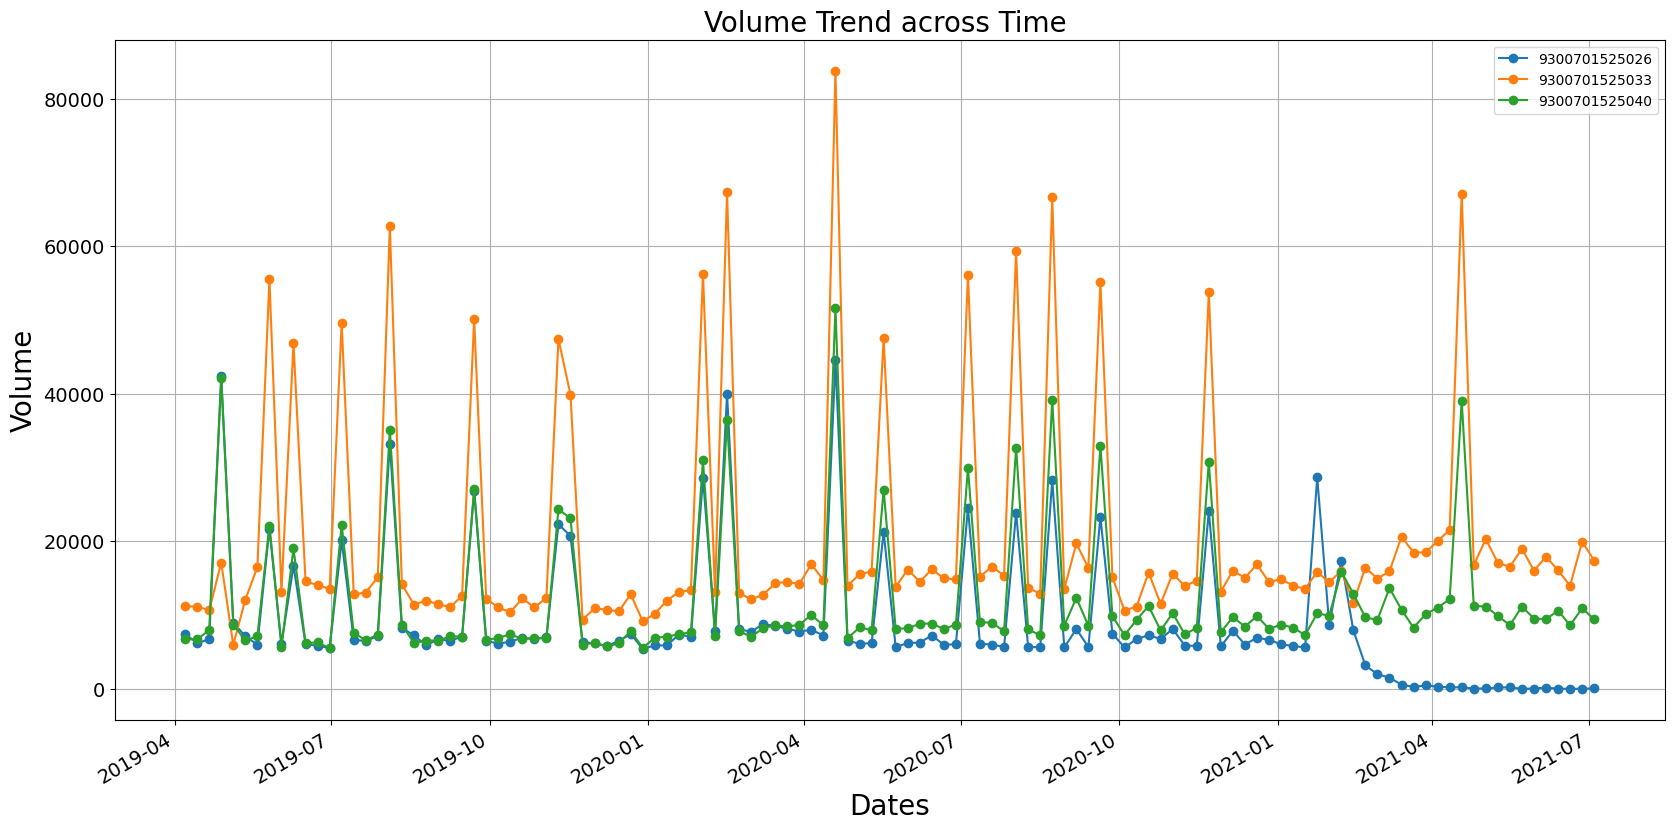

SKU No. 9300701525026 : ['Air Wick Essential Mist Diffuser Rfl Fresh Water Breeze 20mL'] .
SKU No. 9300701525033 : ['Air Wick Essential Mist Diffuser Refill Peony & Jasmine 20mL'] .
SKU No. 9300701525040 : ['Air Wick Essential Mist Refill Mandarin & Sweet Orange 20mL'] .


In [60]:
T=get_segment(segment,retailer,date)[items+['date','MONTH','YEAR']]
plot_correlated_trendlines(T,date)
for item in T.columns[:-3]:
    print("SKU No. {} : {} .".format(item,item_detail[item]))

### Decomposition of TimeSeries.

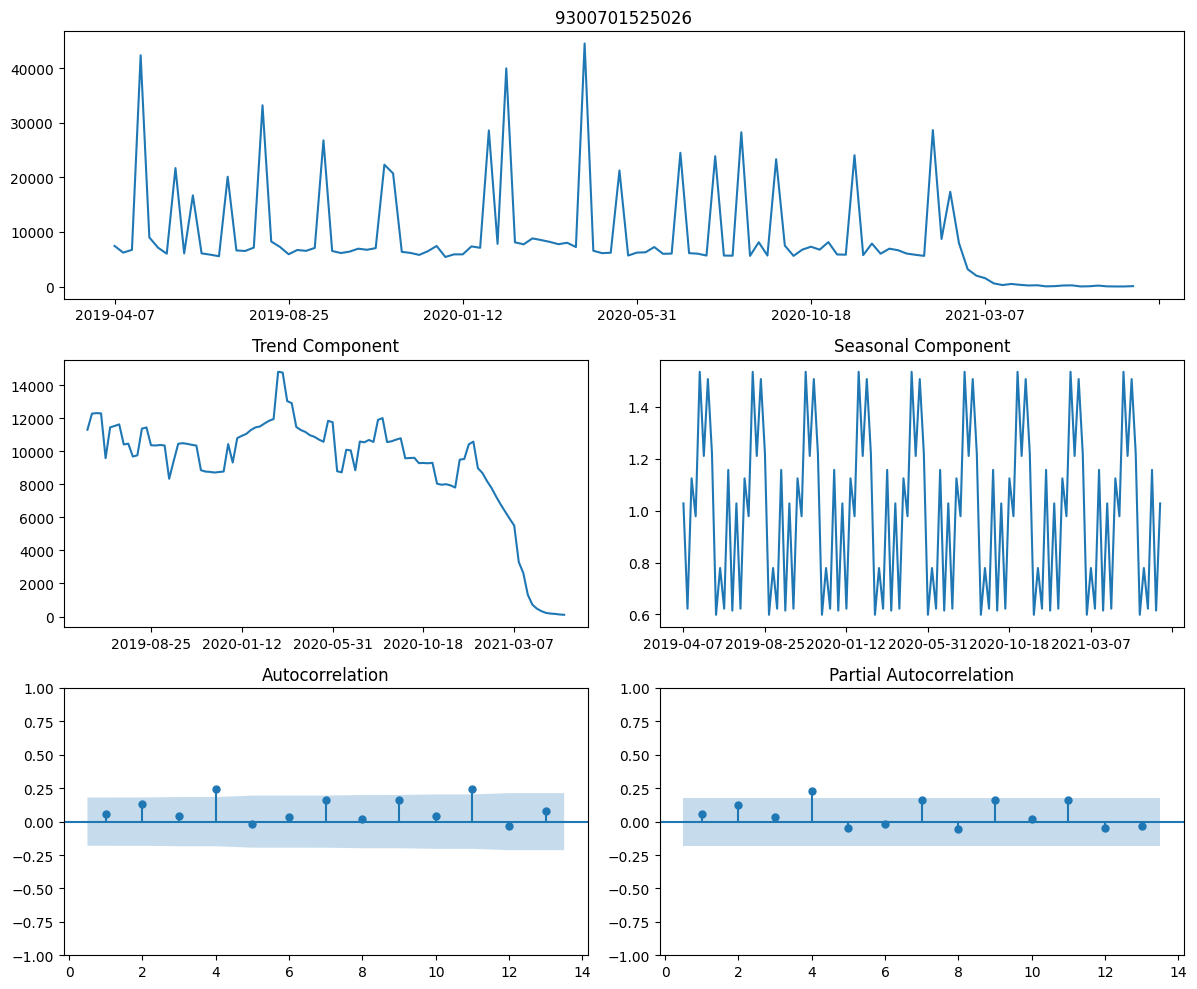

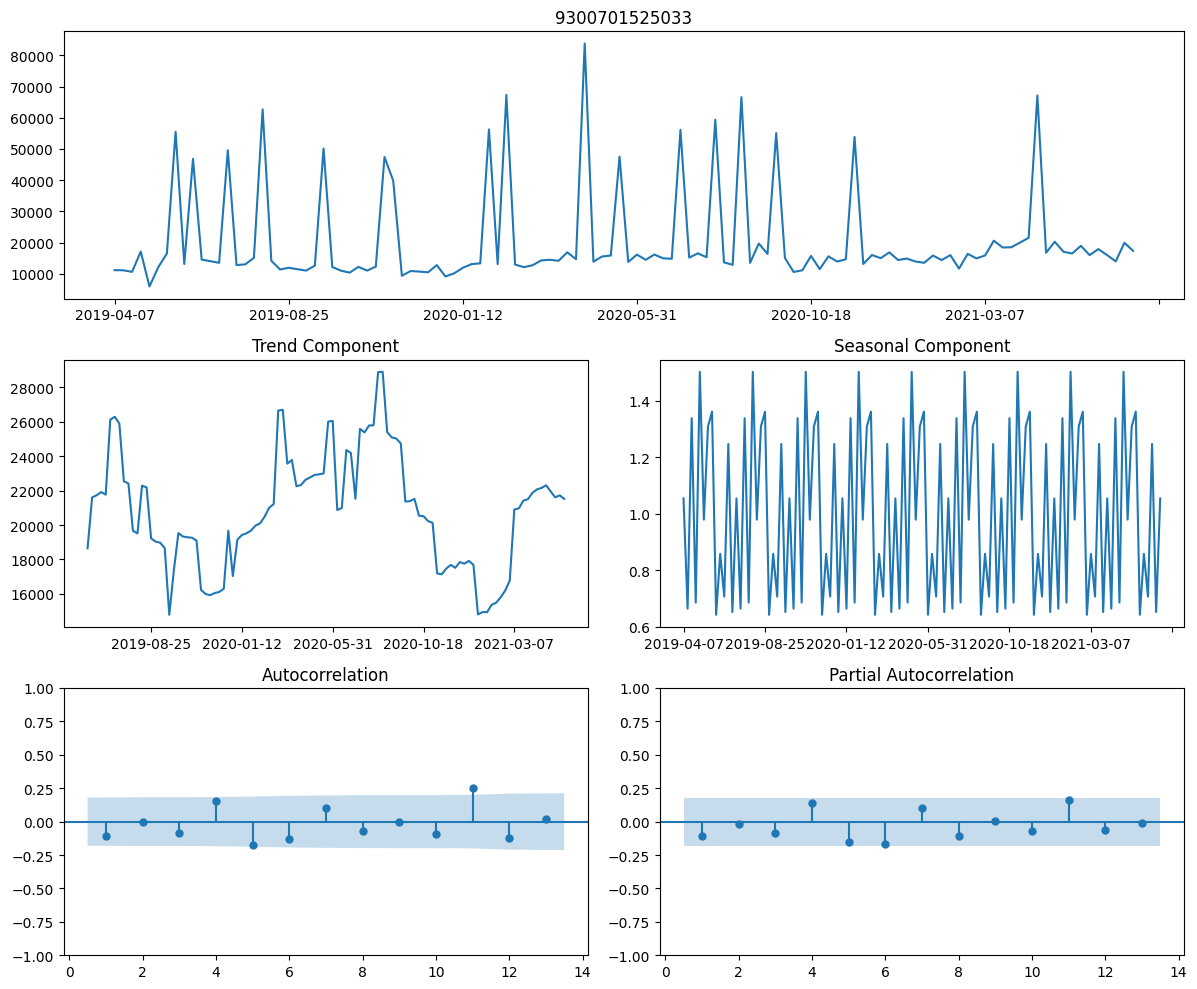

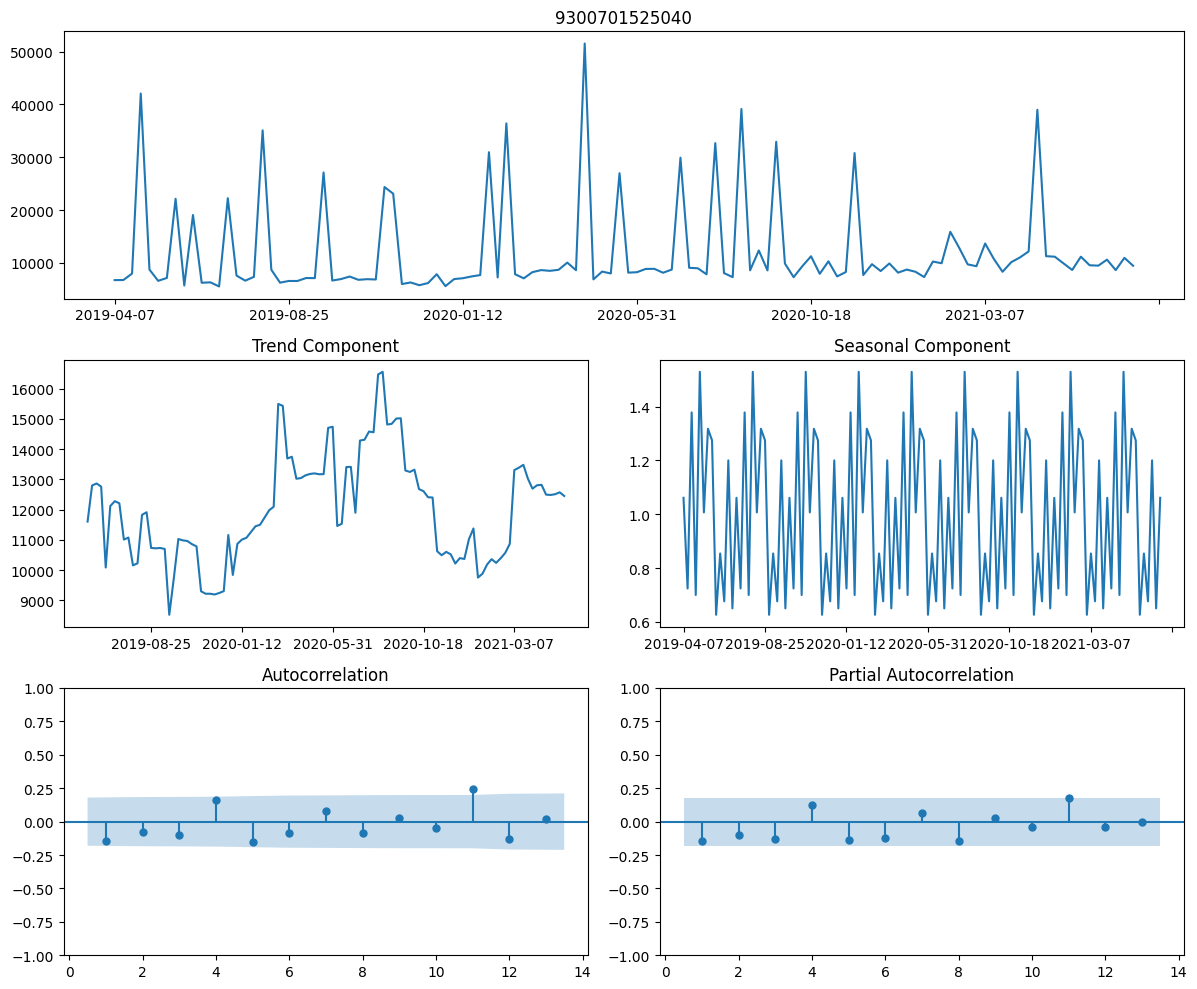

In [61]:
for item in T.columns[:-3]:
    if 0 in T[item].values:
        plot_stationarity(T[item],4,'additive')
    else:
        plot_stationarity(T[item],13,'multiplicative')

### Checking Stationarity

In [62]:
check_stationarity(T)

ADF  \
Item          Results                                             
9300701525026 Test Statistics                            -0.032   
              p-value                                     0.956   
              Differencing Required                        True   
              Conclusion             non-stationary (unit root)   
9300701525033 Test Statistics                           -11.994   
              p-value                                     0.000   
              Differencing Required                       False   
              Conclusion                             stationary   
9300701525040 Test Statistics                           -12.386   
              p-value                                     0.000   
              Differencing Required                       False   
              Conclusion                             stationary   

                                               KPSS  
Item          Results                                
9300701525026 Test Statistics                 1.009  
              p-value                         0.010  
              Differencing Required            True  
              Conclusion             not stationary  
9300701525033 Test Statistics                 0.060  
              p-value                         0.100  
              Differencing Required           False  
              Conclusion                 stationary  
9300701525040 Test Statistics                 0.075  
              p-value                         0.100  
              Differencing Required           False  
              Conclusion                 stationary

###  Descriptive Statistics of TimeSeries.

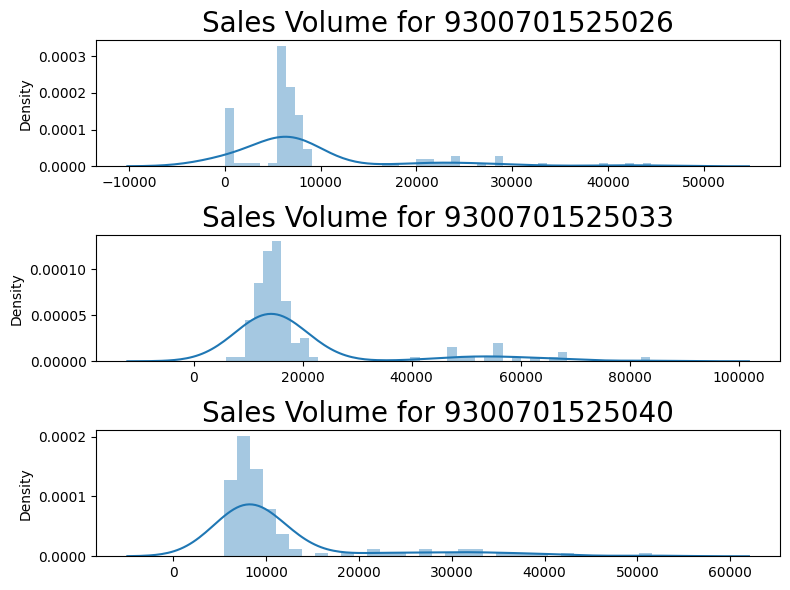

In [63]:
if len(T.columns)==4:
    fig=plt.figure(figsize=(8,6))
    sns.distplot(T[item])
    plt.title('Sales Volume for {}'.format(str(int(item))),fontsize=20)
    plt.xlabel(None,fontsize=16)
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=1,figsize=(8,6))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[item],ax=axes[i])
        axes[i].set_title('Sales Volume for {}'.format(str(int(item))),fontsize=20)
        axes[i].set_xlabel(None,fontsize=16)
    fig.tight_layout()
    plt.show()

In [64]:
T[T.columns[:-3]].describe().T

count      mean       std      min       25%       50%  \
9300701525026 118.000  8883.220  8813.165   20.000  5700.000  6520.000   
9300701525033 118.000 20403.390 15682.806 5980.000 12825.000 14780.000   
9300701525040 118.000 11942.712  9038.970 5520.000  7280.000  8590.000   

                    75%       max  
9300701525026  7940.000 44520.000  
9300701525033 17040.000 83780.000  
9300701525040 10705.000 51560.000

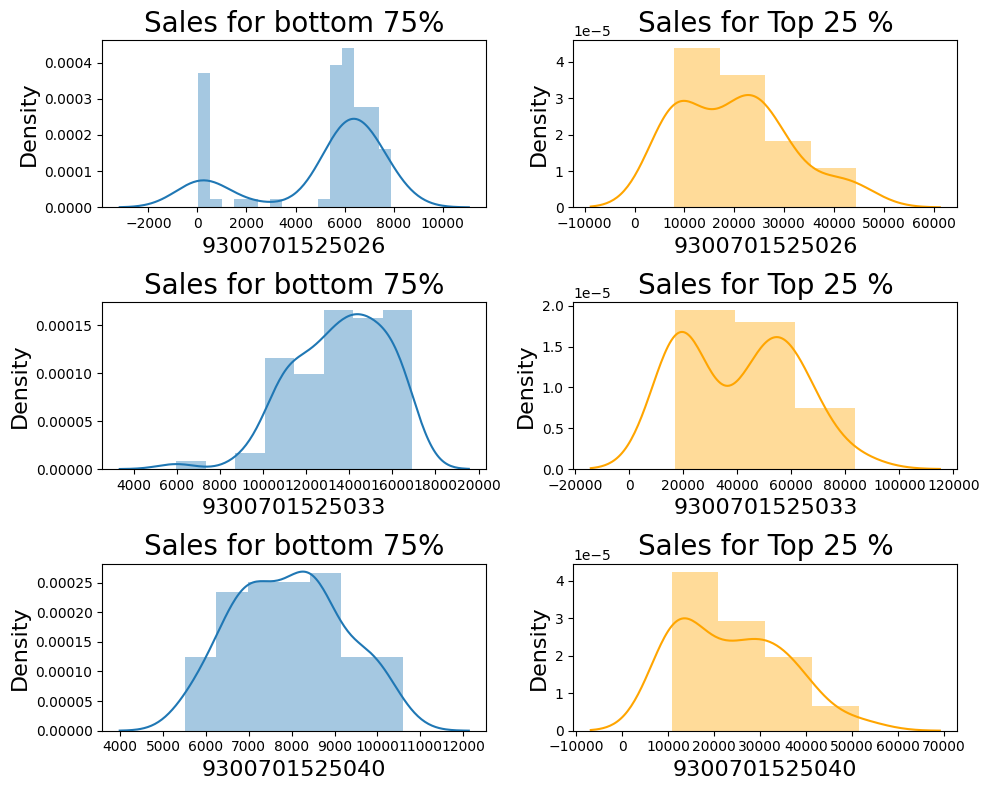

In [65]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=2,figsize=(10,8))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[T[item]<=T[item].describe()['75%']][item],ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
        axes[0].set_xlabel(item,fontsize=16)
        axes[0].set_ylabel('Density',fontsize=16)
    
        sns.distplot(T[T[item]>T[item].describe()['75%']][item],ax=axes[1],color='orange')
        axes[1].set_title('Sales for Top 25 %',fontsize=20)
        axes[1].set_xlabel(item,fontsize=16)
        axes[1].set_ylabel('Density',fontsize=16)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=2,figsize=(10,8))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[T[item]<=T[item].describe()['75%']][item],ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
        axes[i,0].set_xlabel(item,fontsize=16)
        axes[i,0].set_ylabel('Density',fontsize=16)
        
        sns.distplot(T[T[item]>T[item].describe()['75%']][item],ax=axes[i,1],color='orange')
        axes[i,1].set_title('Sales for Top 25 %',fontsize=20)
        axes[i,1].set_xlabel(item,fontsize=16)
        axes[i,1].set_ylabel('Density',fontsize=16)
    fig.tight_layout()
    plt.show()

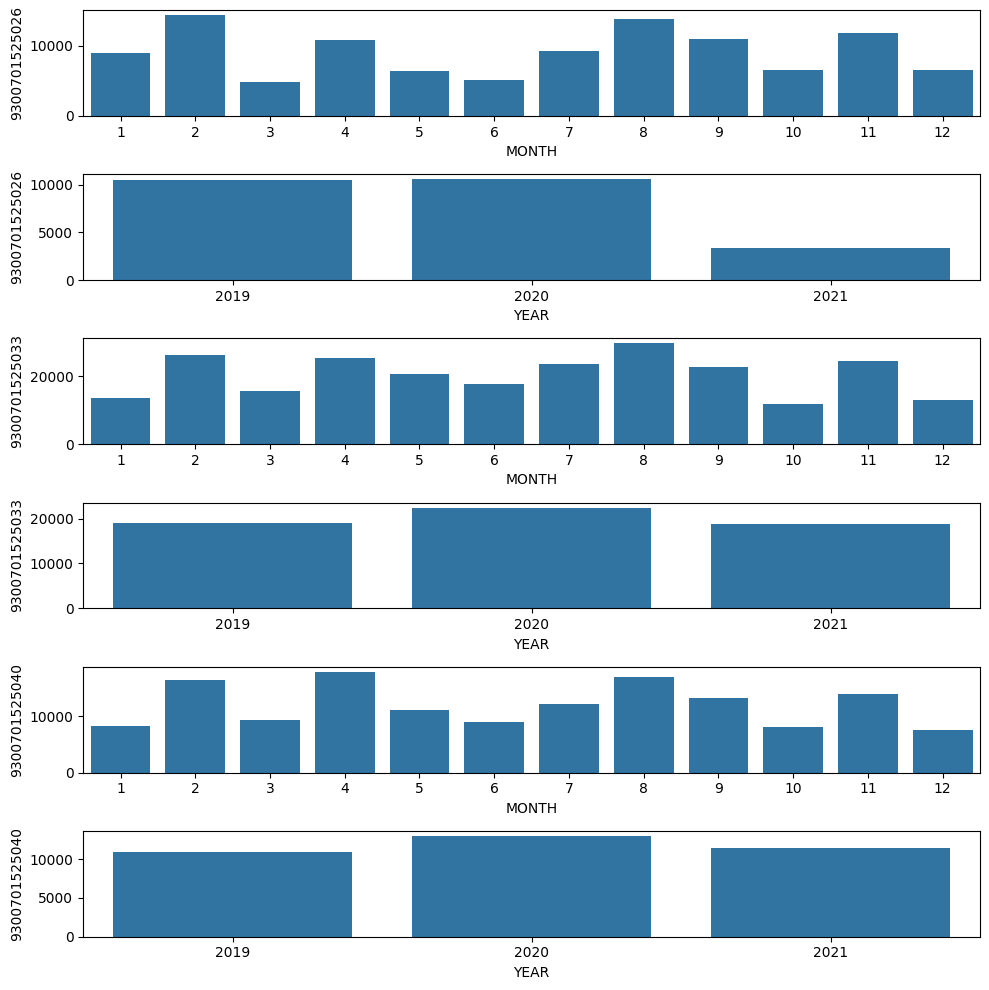

In [66]:
fig,axes=plt.subplots(nrows=(T.shape[1]-3)*2,ncols=1,figsize=(10,10))
for i,item in enumerate(T.columns[:-3]):
    sns.barplot(x='MONTH',y=item,data=T,ci=0,orient='v',ax=axes[i*2])
    sns.barplot(x='YEAR',y=item,data=T,ci=0,orient='v',ax=axes[(i*2)+1])
fig.tight_layout()
plt.show()

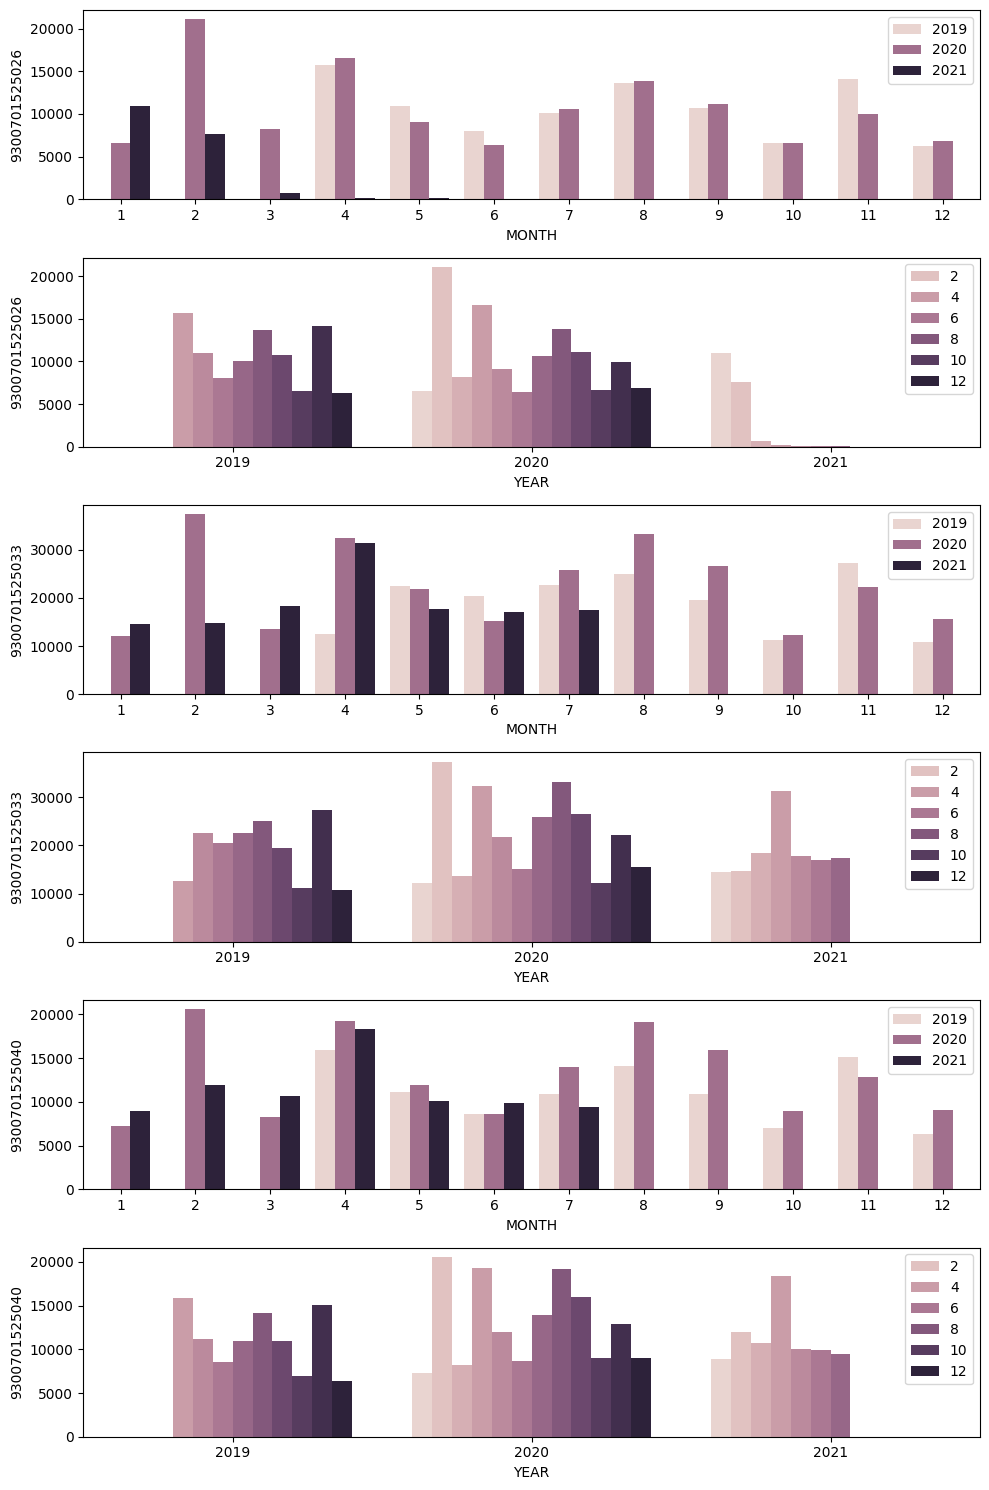

In [67]:
fig,axes=plt.subplots(nrows=(T.shape[1]-3)*2,ncols=1,figsize=(10,15))
for i,item in enumerate(T.columns[:-3]):
    
    sns.barplot(x='MONTH',y=item,data=T,hue='YEAR',ci=0,orient='v',ax=axes[i*2])
    sns.barplot(x='YEAR',y=item,data=T,hue='MONTH',ci=0,orient='v',ax=axes[(i*2)+1])
    axes[i*2].legend(loc='upper right')
    axes[(i*2)+1].legend(loc='upper right')
fig.tight_layout()
plt.show()

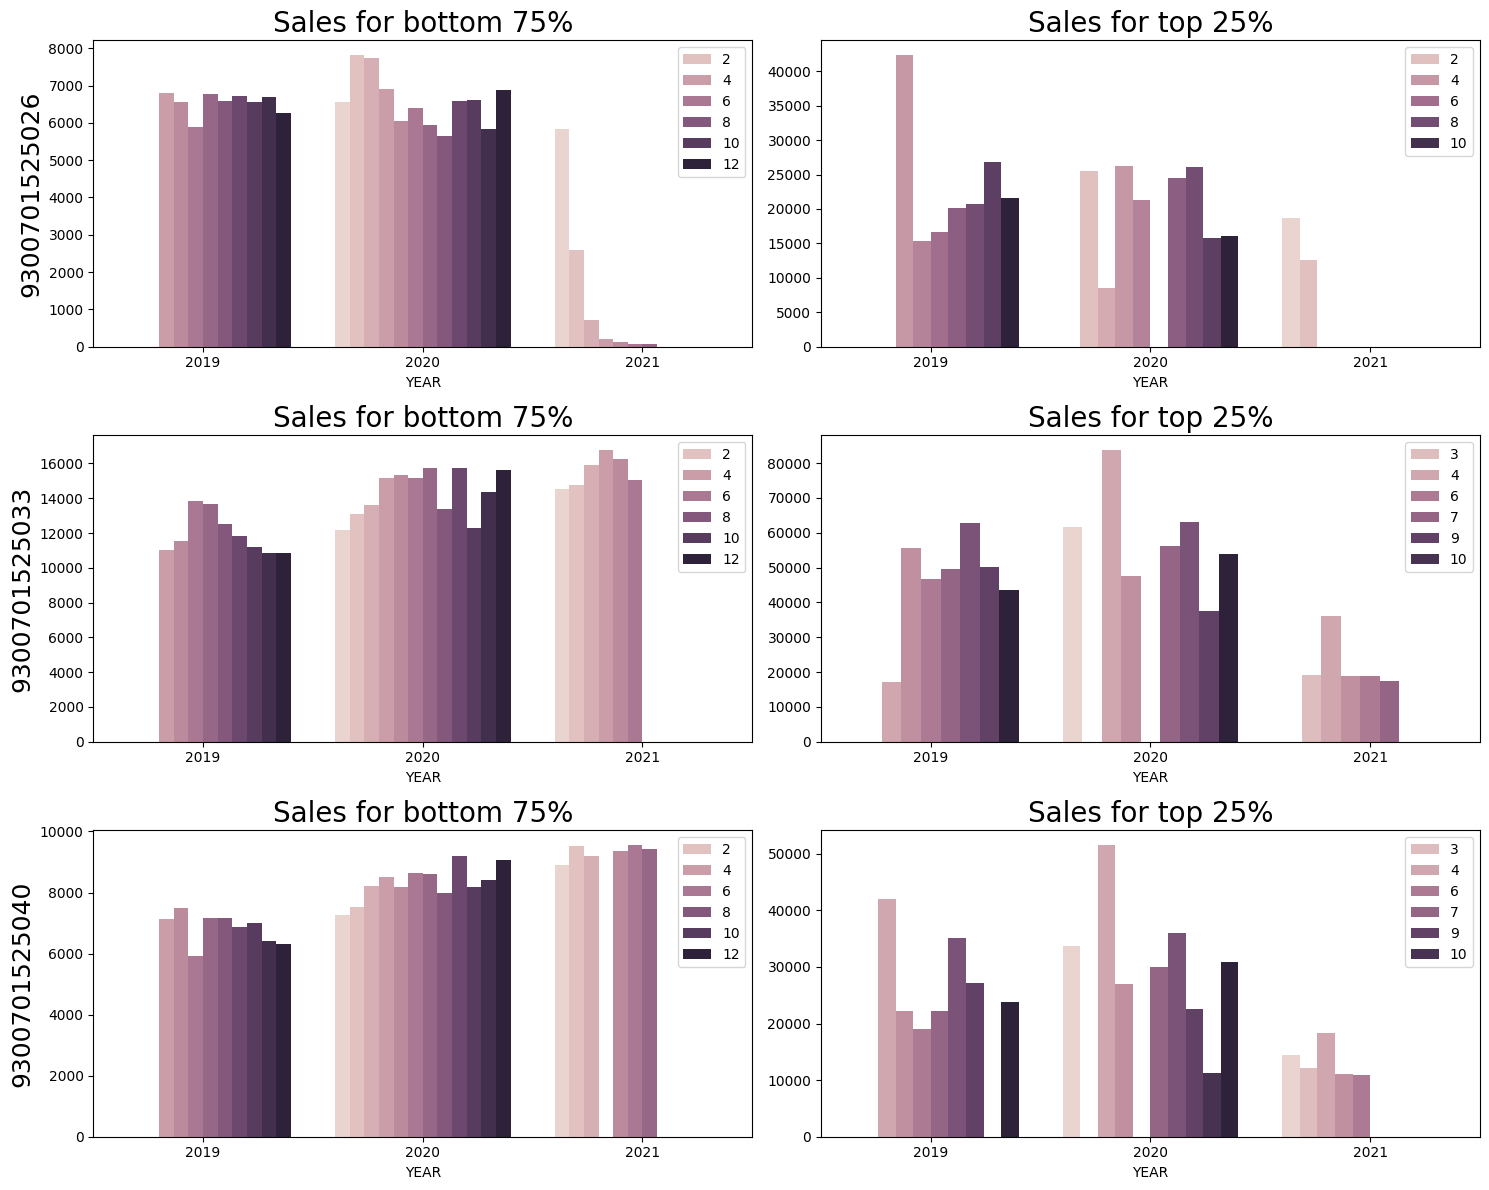

In [68]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
        
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[1])
        axes[1].set_title('Sales for top 25%',fontsize=20)
        
        axes[1].legend(loc='upper right')
        axes[0].legend(loc='upper right')
        
        axes[1].set_ylabel(ylabel=None)
        axes[0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
    
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
        
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[i,1])
        axes[i,1].set_title('Sales for top 25%',fontsize=20)
    
        axes[i,1].legend(loc='upper right')
        axes[i,0].legend(loc='upper right')
    
        axes[i,1].set_ylabel(ylabel=None)
        axes[i,0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()

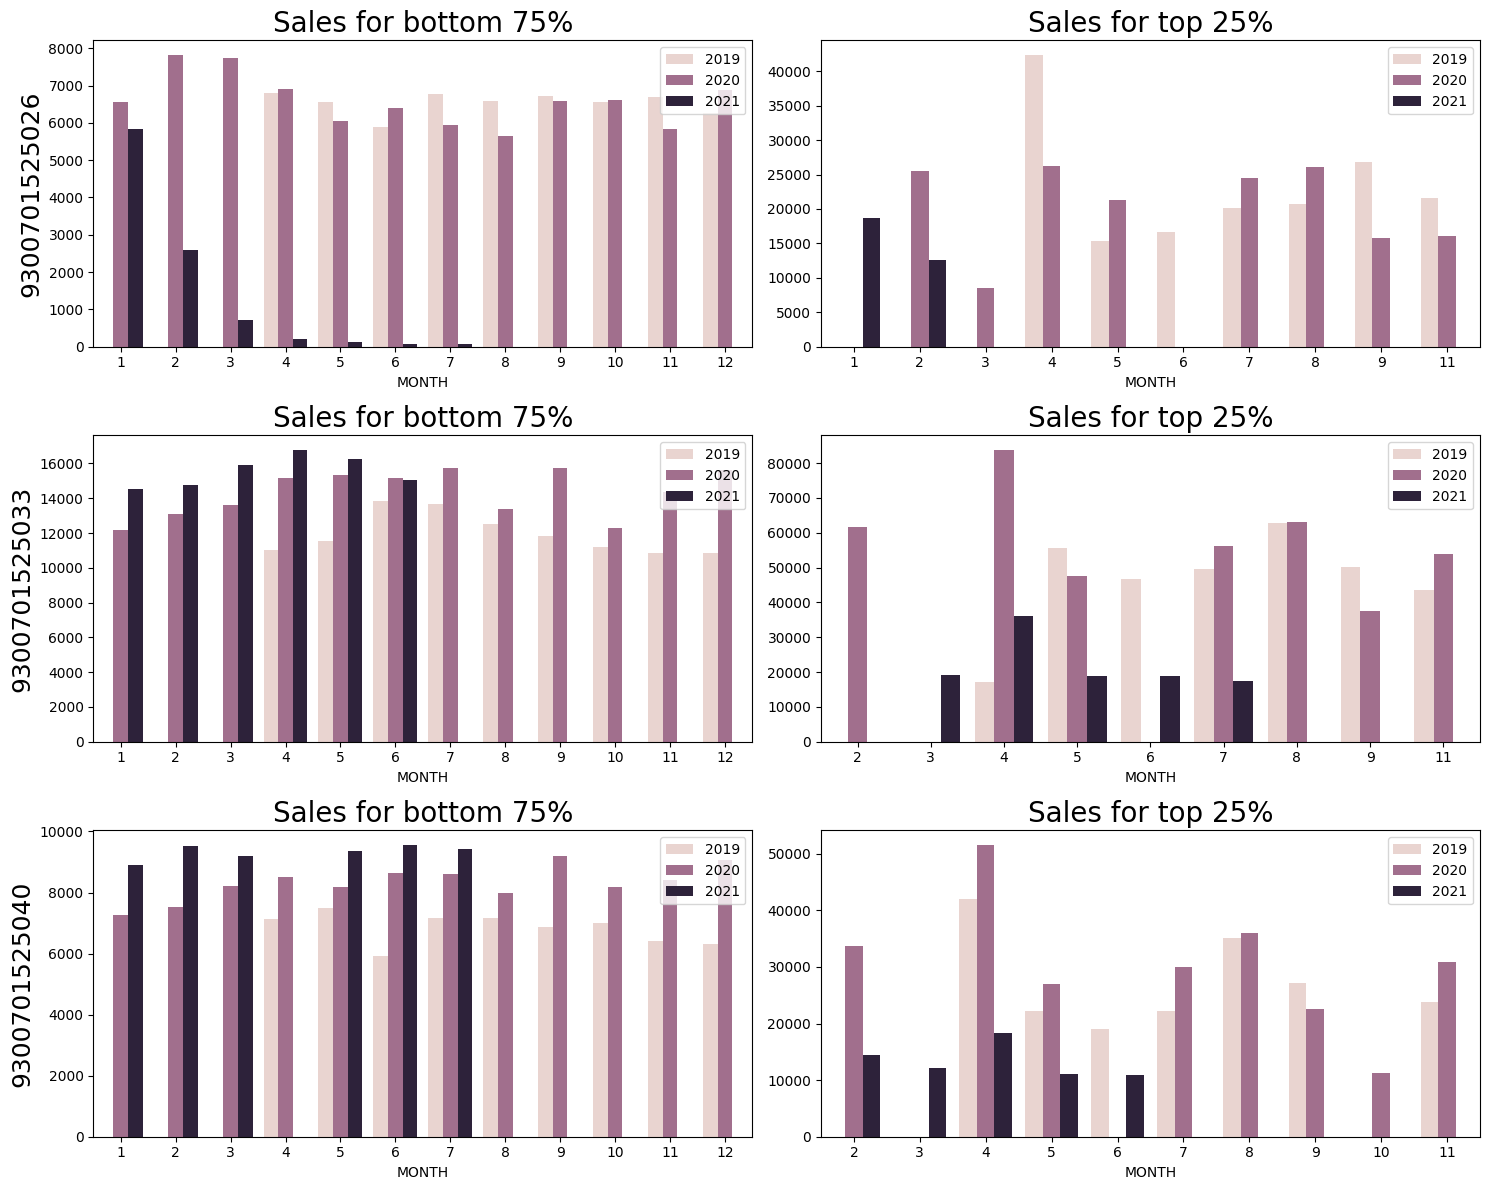

In [69]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
    
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[1])
        axes[1].set_title('Sales for top 25%',fontsize=20)
    
    
        axes[1].legend(loc='upper right')
        axes[0].legend(loc='upper right')
    
        axes[1].set_ylabel(ylabel=None)
        axes[0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
    
        sns.barplot(x='MONTH',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='YEAR',ci=0,orient='v',ax=axes[i,1])
        axes[i,1].set_title('Sales for top 25%',fontsize=20)
    
    
        axes[i,1].legend(loc='upper right')
        axes[i,0].legend(loc='upper right')
    
        axes[i,1].set_ylabel(ylabel=None)
        axes[i,0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()

## Correlated Items Analysis

In [70]:
get_highest(get_corr(segment,retailer),0.8)

Corr
Item_1            Item_2                 
9300701525019.000 9300701744298.000 0.997
9300701525026.000 9300701525040.000 0.822
9300701525033.000 9300701525040.000 0.922
9300701525040.000 9300701525026.000 0.822
                  9300701525033.000 0.922
9300701744298.000 9300701525019.000 0.997

### 2.) [9300701525033, 9300701525040]

In [71]:
items=[9300701525033, 9300701525040]

### Plotting TimeSeries

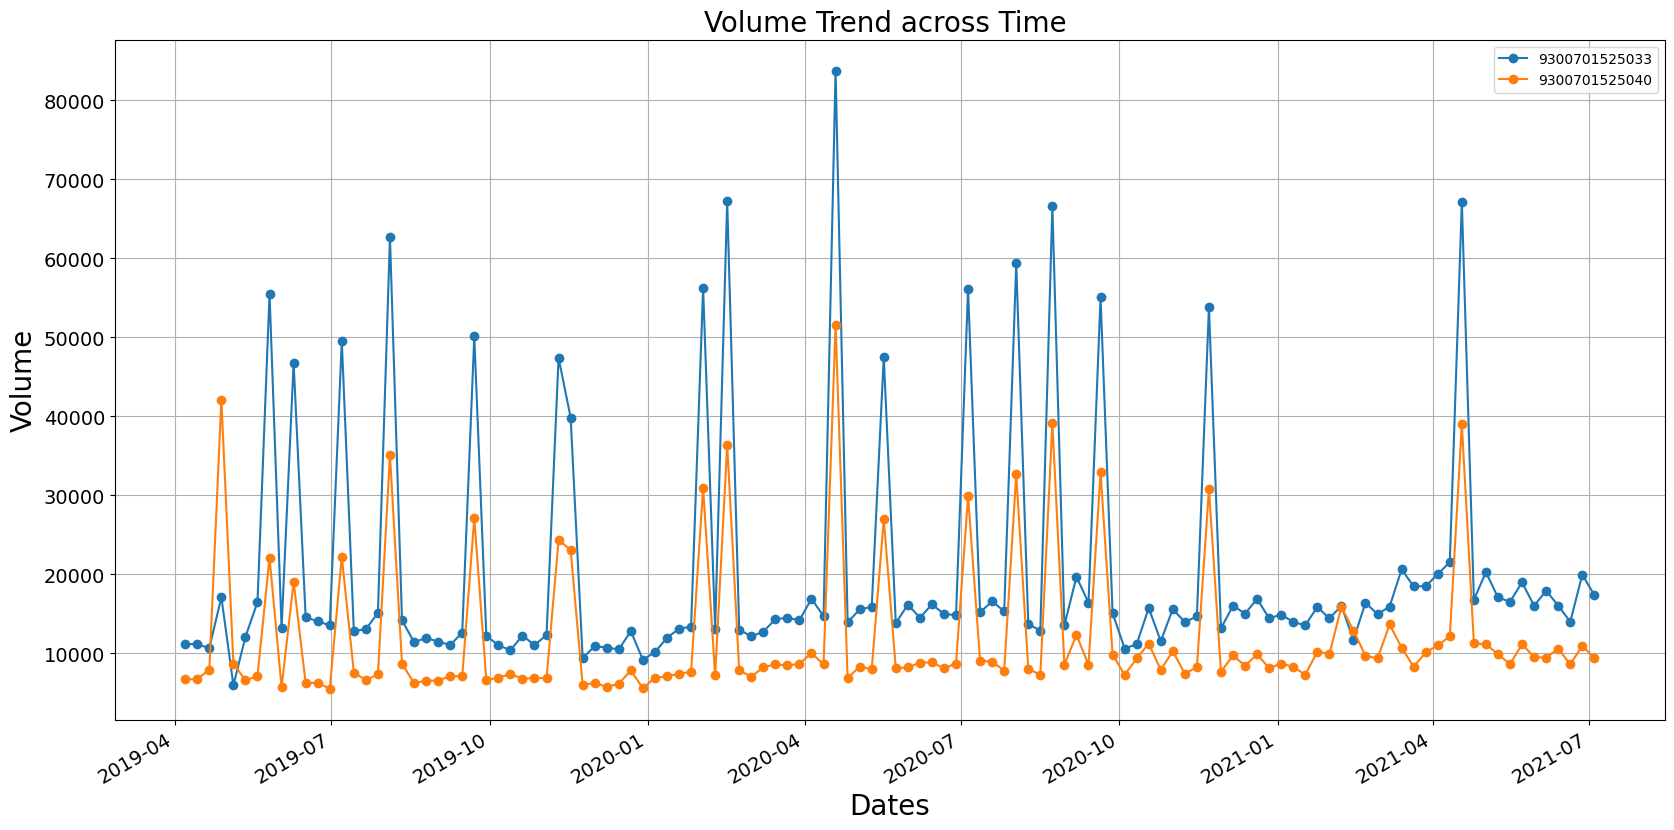

SKU No. 9300701525033 : ['Air Wick Essential Mist Diffuser Refill Peony & Jasmine 20mL'] .
SKU No. 9300701525040 : ['Air Wick Essential Mist Refill Mandarin & Sweet Orange 20mL'] .


In [72]:
T=get_segment(segment,retailer,date)[items+['date','MONTH','YEAR']]
plot_correlated_trendlines(T,date)
for item in T.columns[:-3]:
    print("SKU No. {} : {} .".format(item,item_detail[item]))

### Decomposition of TimeSeries.

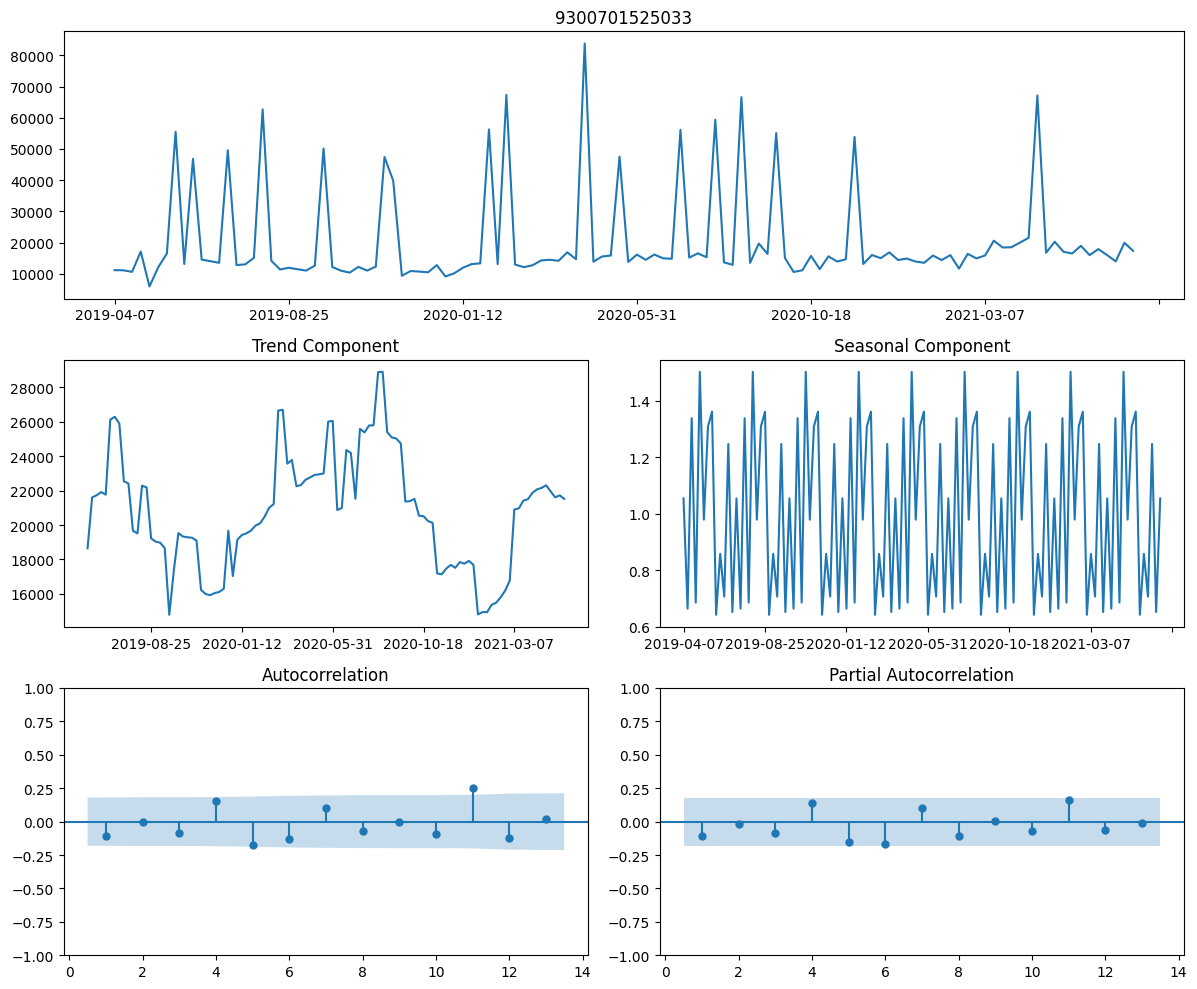

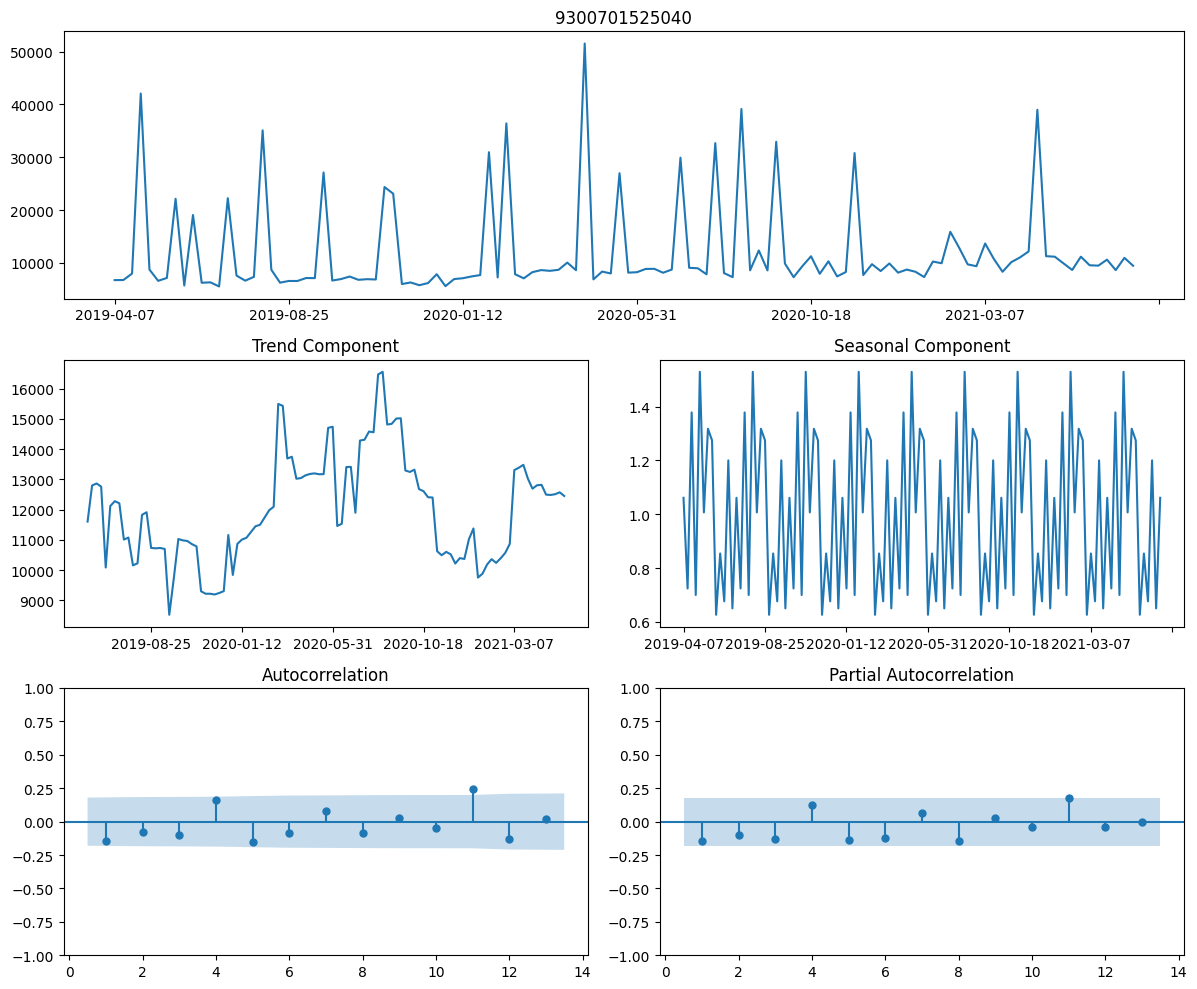

In [73]:
for item in T.columns[:-3]:
    if 0 in T[item].values:
        plot_stationarity(T[item],4,'additive')
    else:
        plot_stationarity(T[item],13,'multiplicative')

### Checking Stationarity

In [74]:
check_stationarity(T)

ADF        KPSS
Item          Results                                      
9300701525033 Test Statistics           -11.994       0.060
              p-value                     0.000       0.100
              Differencing Required       False       False
              Conclusion             stationary  stationary
9300701525040 Test Statistics           -12.386       0.075
              p-value                     0.000       0.100
              Differencing Required       False       False
              Conclusion             stationary  stationary

###  Descriptive Statistics of TimeSeries.

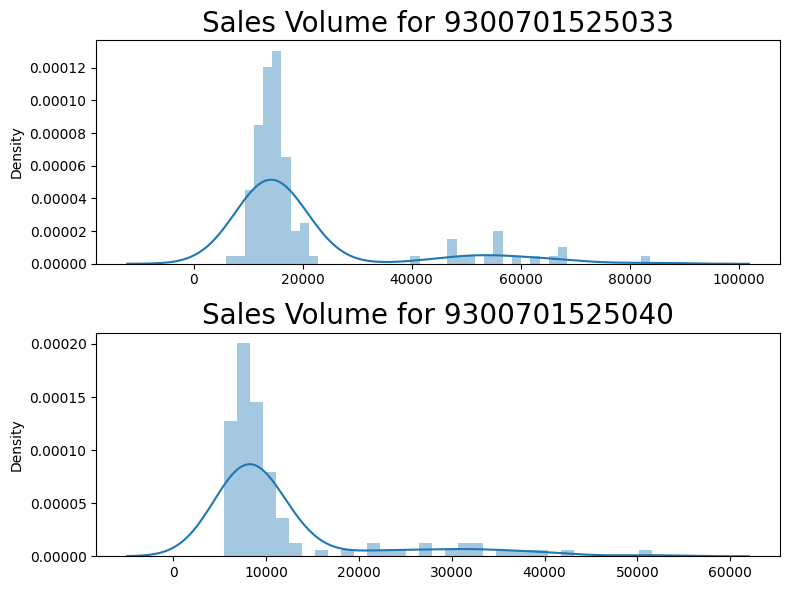

In [75]:
if len(T.columns)==4:
    fig=plt.figure(figsize=(8,6))
    sns.distplot(T[item])
    plt.title('Sales Volume for {}'.format(str(int(item))),fontsize=20)
    plt.xlabel(None,fontsize=16)
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=1,figsize=(8,6))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[item],ax=axes[i])
        axes[i].set_title('Sales Volume for {}'.format(str(int(item))),fontsize=20)
        axes[i].set_xlabel(None,fontsize=16)
    fig.tight_layout()
    plt.show()

In [76]:
T[T.columns[:-3]].describe().T

count      mean       std      min       25%       50%  \
9300701525033 118.000 20403.390 15682.806 5980.000 12825.000 14780.000   
9300701525040 118.000 11942.712  9038.970 5520.000  7280.000  8590.000   

                    75%       max  
9300701525033 17040.000 83780.000  
9300701525040 10705.000 51560.000

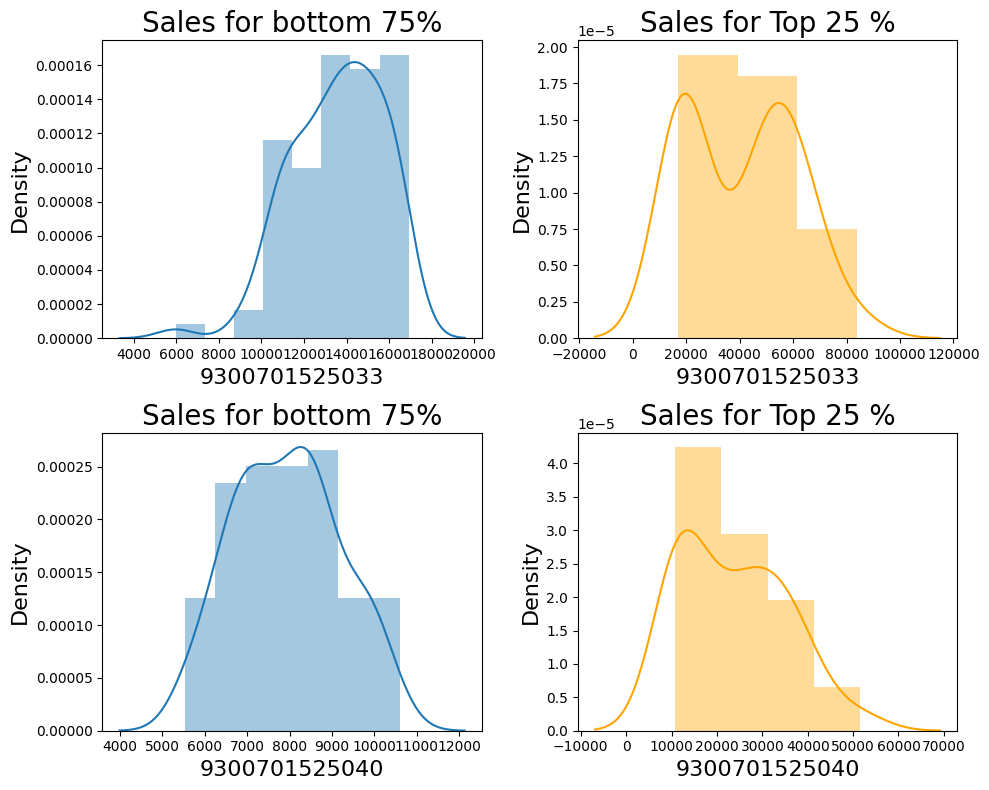

In [77]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=2,figsize=(10,8))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[T[item]<=T[item].describe()['75%']][item],ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
        axes[0].set_xlabel(item,fontsize=16)
        axes[0].set_ylabel('Density',fontsize=16)
    
        sns.distplot(T[T[item]>T[item].describe()['75%']][item],ax=axes[1],color='orange')
        axes[1].set_title('Sales for Top 25 %',fontsize=20)
        axes[1].set_xlabel(item,fontsize=16)
        axes[1].set_ylabel('Density',fontsize=16)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3),ncols=2,figsize=(10,8))
    for i,item in enumerate(T.columns[:-3]):
        sns.distplot(T[T[item]<=T[item].describe()['75%']][item],ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
        axes[i,0].set_xlabel(item,fontsize=16)
        axes[i,0].set_ylabel('Density',fontsize=16)
        
        sns.distplot(T[T[item]>T[item].describe()['75%']][item],ax=axes[i,1],color='orange')
        axes[i,1].set_title('Sales for Top 25 %',fontsize=20)
        axes[i,1].set_xlabel(item,fontsize=16)
        axes[i,1].set_ylabel('Density',fontsize=16)
    fig.tight_layout()
    plt.show()

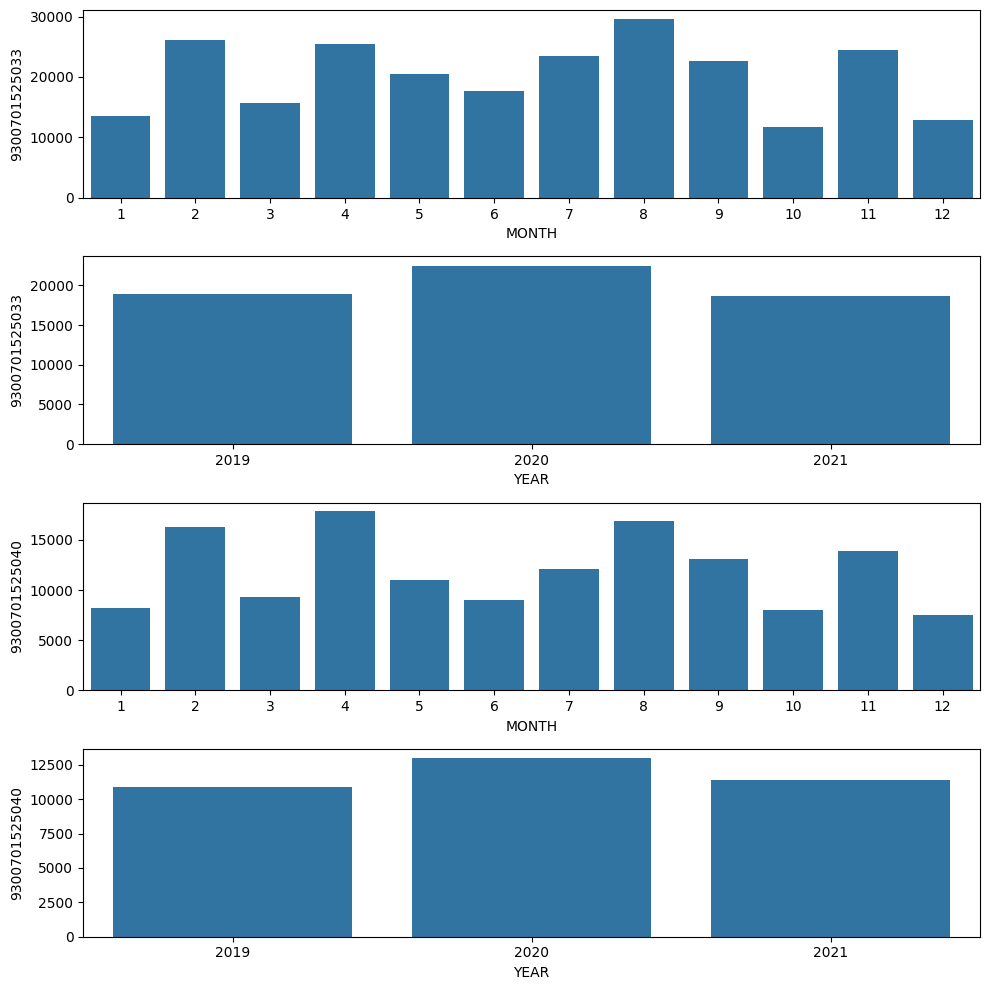

In [78]:
fig,axes=plt.subplots(nrows=(T.shape[1]-3)*2,ncols=1,figsize=(10,10))
for i,item in enumerate(T.columns[:-3]):
    sns.barplot(x='MONTH',y=item,data=T,ci=0,orient='v',ax=axes[i*2])
    sns.barplot(x='YEAR',y=item,data=T,ci=0,orient='v',ax=axes[(i*2)+1])
fig.tight_layout()
plt.show()

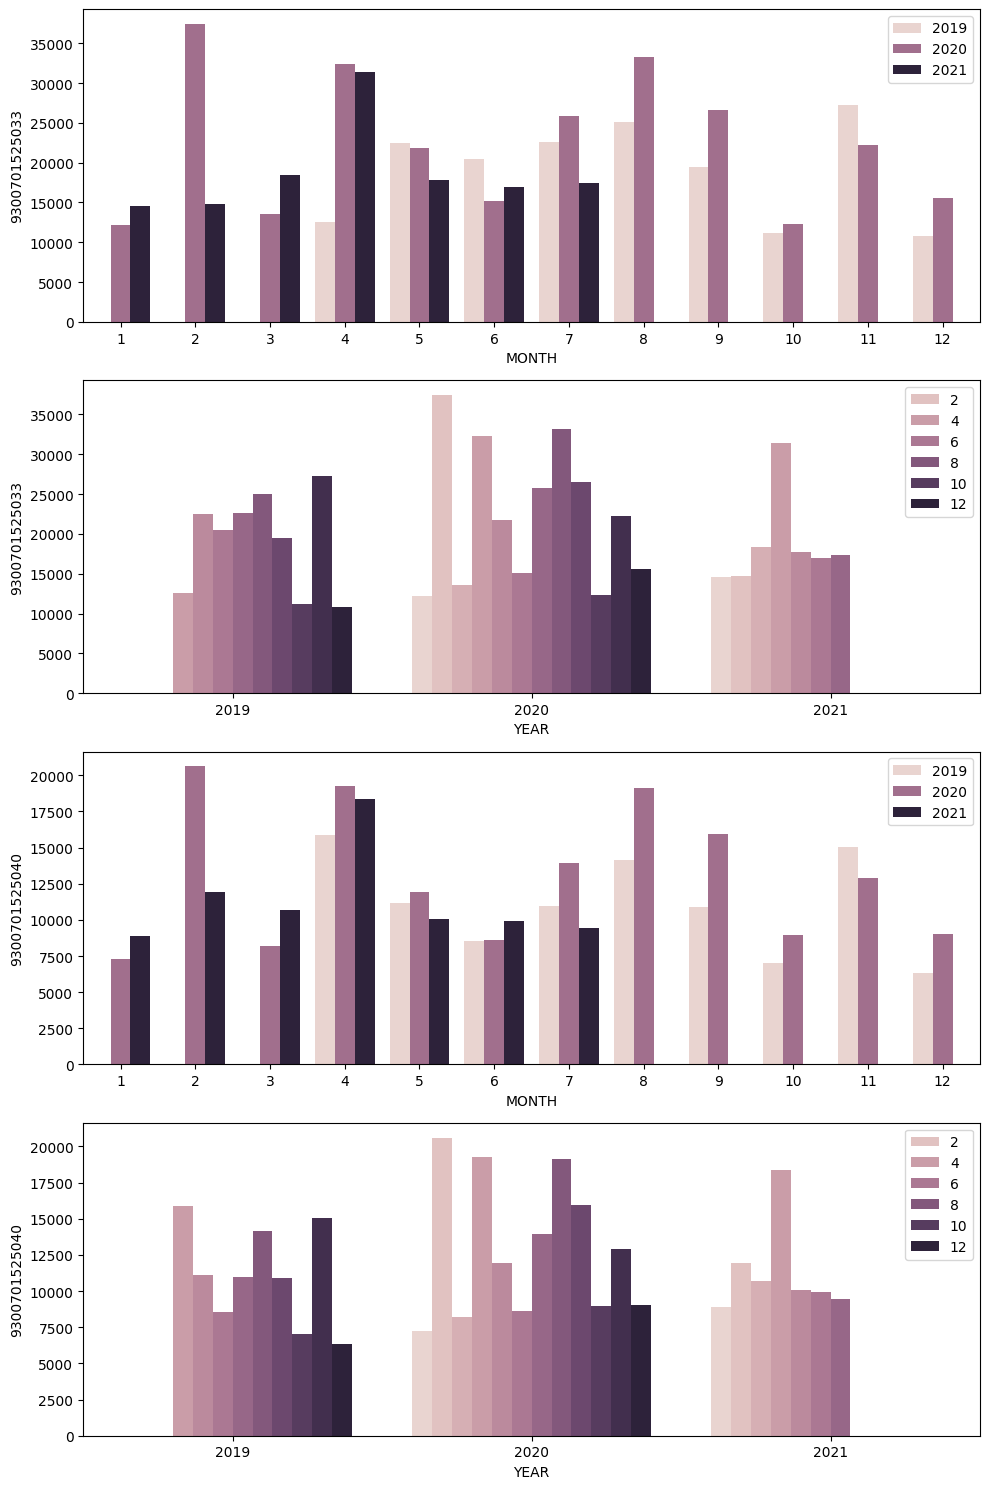

In [79]:
fig,axes=plt.subplots(nrows=(T.shape[1]-3)*2,ncols=1,figsize=(10,15))
for i,item in enumerate(T.columns[:-3]):
    
    sns.barplot(x='MONTH',y=item,data=T,hue='YEAR',ci=0,orient='v',ax=axes[i*2])
    sns.barplot(x='YEAR',y=item,data=T,hue='MONTH',ci=0,orient='v',ax=axes[(i*2)+1])
    axes[i*2].legend(loc='upper right')
    axes[(i*2)+1].legend(loc='upper right')
fig.tight_layout()
plt.show()

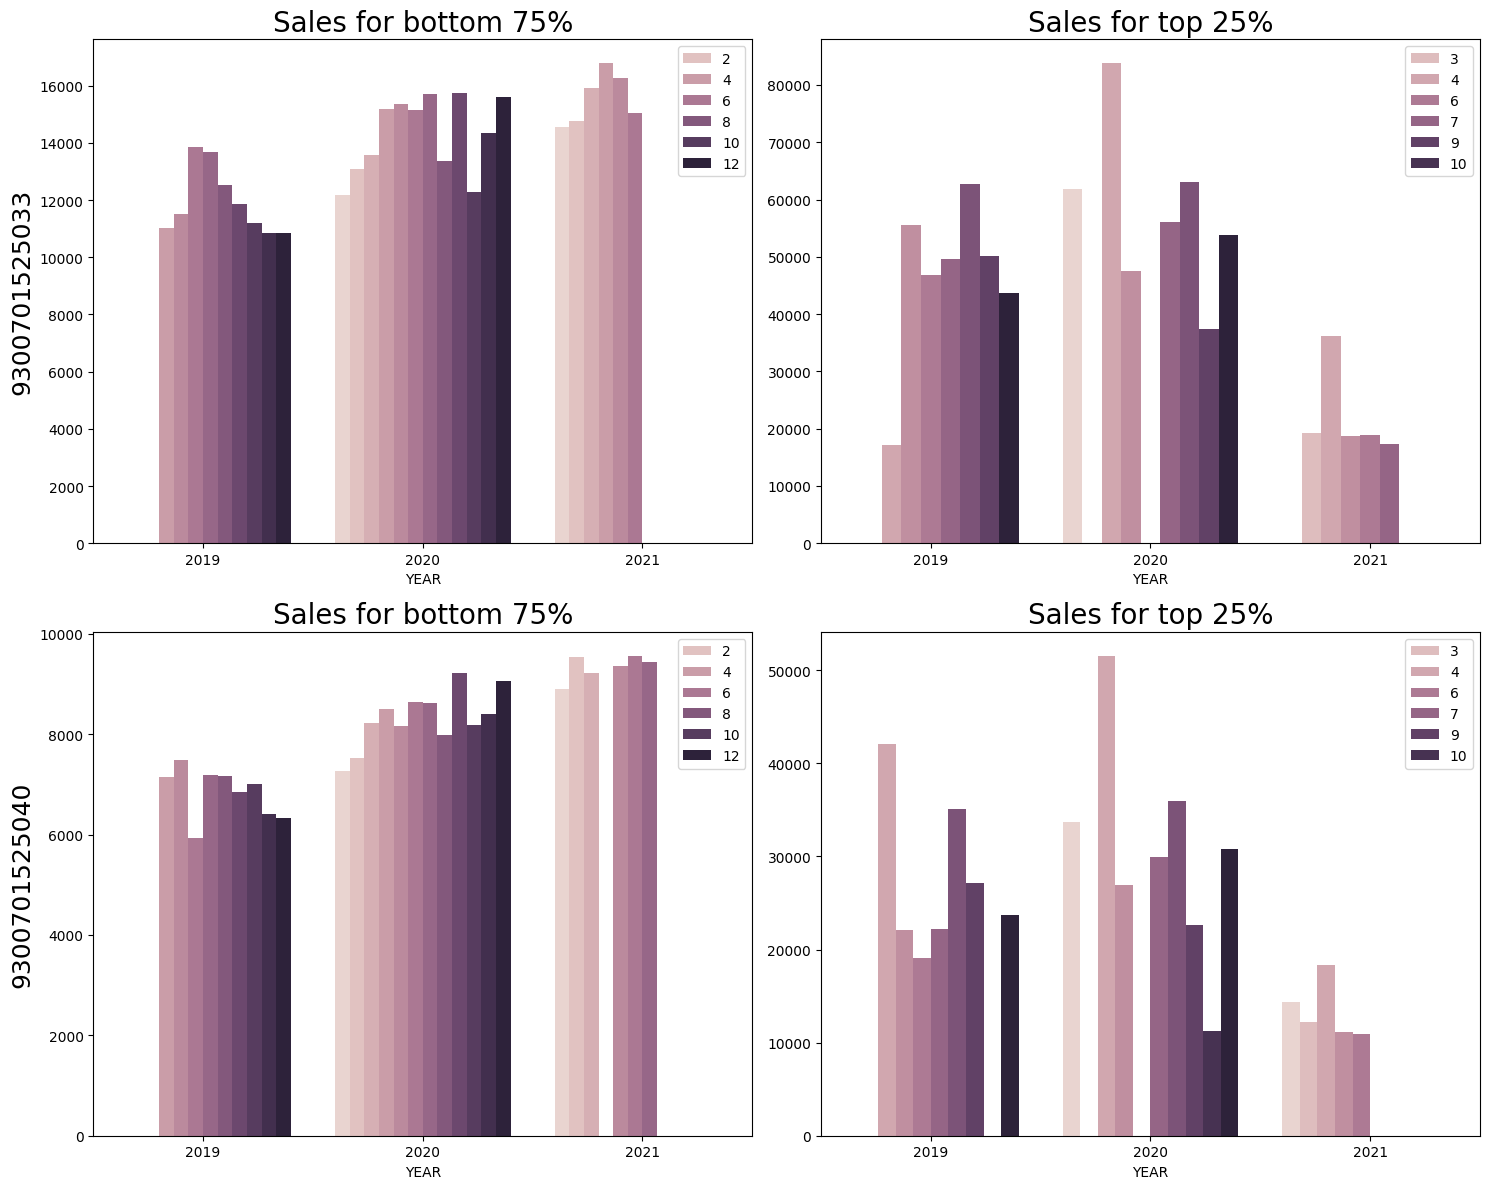

In [80]:
if len(T.columns)==4:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[0])
        axes[0].set_title('Sales for bottom 75%',fontsize=20)
        
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[1])
        axes[1].set_title('Sales for top 25%',fontsize=20)
        
        axes[1].legend(loc='upper right')
        axes[0].legend(loc='upper right')
        
        axes[1].set_ylabel(ylabel=None)
        axes[0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()
else:
    fig,axes=plt.subplots(nrows=(T.shape[1]-3)*1,ncols=2,figsize=(15,12))
    for i,item in enumerate(T.columns[:-3]):
    
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x<=T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[i,0])
        axes[i,0].set_title('Sales for bottom 75%',fontsize=20)
        
        sns.barplot(x='YEAR',y=item,data=T[T[item].apply(lambda x:x>T[item].describe()['75%'])],hue='MONTH',ci=0,orient='v',ax=axes[i,1])
        axes[i,1].set_title('Sales for top 25%',fontsize=20)
    
        axes[i,1].legend(loc='upper right')
        axes[i,0].legend(loc='upper right')
    
        axes[i,1].set_ylabel(ylabel=None)
        axes[i,0].set_ylabel(ylabel=item,fontsize=18)
    fig.tight_layout()
    plt.show()